[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyPartMC/blob/main/examples/chamber.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/chamber.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/chamber.ipynb)    
[![ARM JupyterHub](https://img.shields.io/static/v1?label=launch%20in&logo=jupyter&color=lightblue&message=ARM+JupyterHub)](https://jupyterhub.arm.gov/hub/user-redirect/git-pull?repo=https%3A//github.com/open-atmos/PyPartMC&branch=main&urlPath=) (requires [logging in with ARM account](https://www.arm.gov/capabilities/computing-resources) and directing Jupyter to a notebook within the cloned repo)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2023 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

#### Chamber Simulation Example from Barrel Study, refer to [Tian el al., 2017 (Aerosol Science and Technology)](https://doi.org/10.1080/02786826.2017.1311988)

#### Equations and parameters in this notebook
1. **Wall-loss treatment**
* Diffusional wall-loss
    ##### $\alpha^{D}_{\mu}$ = $\frac{D(R_{me,\mu})A_D}{\delta_DV}$

* Sedimental wall-loss
    ##### $\alpha^{S}_{\mu}$ = $\frac{4\pi \rho R^{3}_{m, \mu}D(R_{me,\mu})A_S}{3kTV}$

* Parameters:
    - $D(R_{me,\mu})$ $\rm (m^2s^{-1})$: Diffusion coefficient for particle $\mu$
    - $A_D$ $\rm (m^2)$: Diffusional depostion area
        - Variable name: "area_diffuse"
    - $A_S$ $\rm (m^2)$: Sedimentation area
        - Variable name: "area_sedi"
    - V $\rm (m^3)$: Volume of the chamber
        - Variable name: "chamber_vol"
    - $\delta_D$ $(\rm m)$: Diffusional boundary layer thickness
    
    - $\delta_D$ = $k_D$ $\left(\frac{D}{D_0}\right)^a$
    - $k_D$: Chamber-specific parameter.
        - Variable name: "prefactor_BL"
        - Can be determined for each experimental setup
    - $a$: 0.25, Theoretically determined coefficient, [Fuchs, N. A. (1964). Mechanics of Aerosols.Pergamon, New York].
        - Variable name: "exponent_BL"
        - It should be in the range of (1, 3).

2. **Fractal Treatment**

    ##### $ N$ = $\frac{1}{f}$ $\left(\frac{R_{\rm geo}}{R_0}\right)^{d_{\rm f}}$

* Parameters:
    - $N$: Number of monomers in a fractal-like agglomerate
    - $R_{\rm geo}$ $(\rm m)$: Particle geometric radius
    - $f$: Volume filling factor
        - Variable name: "aero_data.vol_fill_factor"
        - For spherical primary particles, this can occupy as much as 74% of the available volume
    - $R_0$ $(\rm m)$: Radius of primary particles
        - Variable name: "aero_data.prime_radius"
    - $d_{\rm f}$: Fractal dimension
        - Variable name: "aero_data.frac_dim"

* Note on Fractal Parameters:
    - $f$, $R_0$ $(\rm m)$: Can be estimated by SEM images
    - $d_{\rm f}$: Needs to be specified



In [2]:
import sys
import os
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')
elif 'JUPYTER_IMAGE' in os.environ and '.arm.gov' in os.environ['JUPYTER_IMAGE']:
    !pip --quiet install PyPartMC open_atmos_jupyter_utils
    _pypartmc_path = !pip show PyPartMC | fgrep Location | cut -f2 -d' '
    sys.path.extend(_pypartmc_path if _pypartmc_path[0] not in sys.path else [])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot
import PyPartMC as ppmc
from PyPartMC import si

In [4]:
gas_data = ppmc.GasData(("H2SO4","HNO3","HCl","NH3","NO","NO2", "NO3",
                        "N2O5", "HONO", "HNO4", "O3", "O1D", "O3P", "OH",
                        "HO2", "H2O2", "CO", "SO2", "CH4", "C2H6", "CH3O2", 
                        "ETHP", "HCHO", "CH3OH", "ANOL", "CH3OOH", "ETHOOH",
                        "ALD2", "HCOOH", "RCOOH", "C2O3", "PAN", "ARO1", "ARO2",
                        "ALK1", "OLE1", "API1", "API2", "LIM1", "LIM2", "PAR", "AONE",
                        "MGLY", "ETH", "OLET", "OLEI", "TOL", "XYL", "CRES", "TO2",
                         "CRO", "OPEN", "ONIT", "ROOH", "RO2", "ANO2", "NAP", "XO2",
                         "XPAR", "ISOP", "ISOPRD", "ISOPP", "ISOPN", "ISOPO2", "API",
                         "LIM", "DMS", "MSA", "DMSO", "DMSO2", "CH3SO2H", "CH3SCH2OO", 
                         "CH3SO2", "CH3SO3", "CH3SO2OO", "CH3SO2CH2OO", "SULFHOX"
                        ))

In [5]:
env_state = ppmc.EnvState(
    {
        "rel_humidity": 0.00,
        "latitude": 0,
        "longitude": 0,
        "altitude": 0 * si.m,
        "start_time": 21600 * si.s,
        "start_day": 200,
    }
)

In [6]:
aero_data = ppmc.AeroData(
    (
        #         density  ions in soln (1) molecular weight    kappa (1)
        #         |                     |   |                   |
        {"SO4": [1760 * si.kg / si.m**3, 1, 96.0 * si.g / si.mol, 0.00]},
        {"NO3": [1800 * si.kg / si.m**3, 1, 62.0 * si.g / si.mol, 0.00]},
        {"Cl": [2200 * si.kg / si.m**3, 1, 35.5 * si.g / si.mol, 0.00]},
        {"NH4": [1760 * si.kg / si.m**3, 1, 18.0 * si.g / si.mol, 0.00]},
        {"MSA": [1800 * si.kg / si.m**3, 0, 95.0 * si.g / si.mol, 0.53]},
        {"ARO1": [1400 * si.kg / si.m**3, 0, 150.0 * si.g / si.mol, 0.10]},
        {"ARO2": [1400 * si.kg / si.m**3, 0, 150.0 * si.g / si.mol, 0.10]},
        {"ALK1": [1400 * si.kg / si.m**3, 0, 140.0 * si.g / si.mol, 0.10]},
        {"OLE1": [1400 * si.kg / si.m**3, 0, 140.0 * si.g / si.mol, 0.10]},
        {"API1": [1400 * si.kg / si.m**3, 0, 184.0 * si.g / si.mol, 0.10]},
        {"API2": [1400 * si.kg / si.m**3, 0, 184.0 * si.g / si.mol, 0.10]},
        {"LIM1": [1400 * si.kg / si.m**3, 0, 200.0 * si.g / si.mol, 0.10]},
        {"LIM2": [1400 * si.kg / si.m**3, 0, 200.0 * si.g / si.mol, 0.10]},
        {"CO3": [2600 * si.kg / si.m**3, 1, 60.0 * si.g / si.mol, 0.00]},
        {"Na": [2200 * si.kg / si.m**3, 1, 23.0 * si.g / si.mol, 0.00]},
        {"Ca": [2600 * si.kg / si.m**3, 1, 40.0 * si.g / si.mol, 0.00]},
        {"OIN": [2600 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.10]},
        {"OC": [1566 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.001]},
        {"BC": [1700 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.00]},
        {"H2O": [1000 * si.kg / si.m**3, 0, 18.0 * si.g / si.mol, 0.00]},
    )
)

#Adjust the following variables for fractal treatment: 
#For spherical particles, comment out the variables.
#aero_data.frac_dim: Should be in the range of (1,3). 
#aero_data.vol_fill_factor: Set this as 1/(percent of the available volume).
aero_data.frac_dim = 2.3
aero_data.vol_fill_factor = 1.43
aero_data.prime_radius = 4.5e-8

In [7]:
gas_state = ppmc.GasState(gas_data)

input_gas_state = (
    {"NO": [0.1E+00]},
)

gas_state.mix_rats = input_gas_state

In [8]:
times = [0 * si.s]
back_gas = [{"time": times},
            {"rate": [0 / si.s]},
            {"NO": [0.1E+00]},
           ]

gas_emit_times = [0]
gas_emit_rates = np.zeros(len(gas_emit_times))
SO2 = [4.234E-09]

emit_gas = [
    {"time": gas_emit_times},
    {"rate": list(gas_emit_rates)},
    {"SO2": SO2},
]

AERO_DIST_BACKGROUND = {
    "back_small": {
        "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 0 / si.m**3,
        "geom_mean_diam": 0.02 * si.um,
        "log10_geom_std_dev": 0.161,
    },
}

AERO_DIST_EMIT = {
    "gasoline": {
        "mass_frac": [{"OC": [0.8]}, {"BC": [0.2]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 0 / si.m**3,
        "geom_mean_diam": 5e-8 * si.m,
        "log10_geom_std_dev": 0.24,
    },
}

In [9]:
time_timeseries = [0]
pressure_timeseries = list(np.ones(1) * 1e5)
temp_timeseries = [293.4]
height_timeseries = [1000]

In [10]:
scenario = ppmc.Scenario(
    gas_data,
    aero_data,
    {
        "temp_profile": [{"time": time_timeseries}, {"temp": temp_timeseries}],
        "pressure_profile": [
            {"time": time_timeseries},
            {"pressure": pressure_timeseries},
        ],
        "height_profile": [{"time": time_timeseries}, {"height": height_timeseries}],
        "gas_emissions": emit_gas,
        "gas_background": back_gas,
        "aero_emissions": [
            {"time": [0 * si.s]},
            {"rate": [0 / si.s]},
            {"dist": [[AERO_DIST_EMIT]]},
        ],
        "aero_background": [
            {"time": [0 * si.s]},
            {"rate": [2.293e-5 / si.s]},
            {"dist": [[AERO_DIST_BACKGROUND]]},
        ],
        
        #Adjust the following variables for wall-loss treatment.
        
        "loss_function": "chamber",
        "chamber_vol": 0.2093,
        "area_diffuse": 1.988,
        "area_sedi": 0.2463,
        "prefactor_BL": 0.06, 
        "exponent_BL": 0.26, 
    },
)

In [11]:
T_INITIAL = 0.0
scenario.init_env_state(env_state, T_INITIAL)

In [12]:
diams = [1.33567e-08, 1.38477e-08, 1.43478e-08, 1.48479e-08, 1.53971e-08,
       1.59972e-08, 1.65481e-08, 1.71464e-08, 1.77975e-08, 1.84467e-08,
       1.91468e-08, 1.98469e-08, 2.05470e-08, 2.12962e-08, 2.20964e-08,
       2.28965e-08, 2.36966e-08, 2.45459e-08, 2.54460e-08, 2.63953e-08,
       2.73954e-08, 2.83956e-08, 2.94449e-08, 3.05450e-08, 3.16452e-08,
       3.27945e-08, 3.39947e-08, 3.52440e-08, 3.65442e-08, 3.78444e-08,
       3.92428e-08, 4.06940e-08, 4.21433e-08, 4.36927e-08, 4.52929e-08,
       4.69423e-08, 4.86917e-08, 5.04920e-08, 5.23414e-08, 5.42417e-08,
       5.62402e-08, 5.83406e-08, 6.04409e-08, 6.26394e-08, 6.49398e-08,
       6.72893e-08, 6.97388e-08, 7.23374e-08, 7.50379e-08, 7.77383e-08,
       8.05369e-08, 8.35356e-08, 8.66361e-08, 8.97857e-08, 9.30354e-08,
       9.64341e-08, 9.99838e-08, 1.03633e-07, 1.07432e-07, 1.11382e-07,
       1.15481e-07, 1.19731e-07, 1.24080e-07, 1.28629e-07, 1.33378e-07,
       1.38228e-07, 1.43276e-07, 1.48526e-07, 1.53975e-07, 1.59625e-07,
       1.65473e-07, 1.71572e-07, 1.77871e-07, 1.84370e-07, 1.91119e-07,
       1.98118e-07, 2.05367e-07, 2.12866e-07, 2.20664e-07, 2.28763e-07,
       2.37112e-07, 2.45810e-07, 2.54858e-07, 2.64207e-07, 2.73856e-07,
       2.83854e-07, 2.94252e-07, 3.05050e-07, 3.16249e-07, 3.27847e-07,
       3.39845e-07, 3.52293e-07, 3.65191e-07, 3.78539e-07, 3.92387e-07,
       4.06784e-07, 4.21732e-07, 4.37180e-07, 4.53177e-07, 4.69774e-07,
       4.86971e-07, 5.04818e-07, 5.23316e-07, 5.42462e-07, 5.62309e-07,
       5.82905e-07, 6.04302e-07, 6.26449e-07, 6.49395e-07, 6.73191e-07,
       6.97837e-07, 7.23383e-07, 7.49878e-07, 7.77374e-07, 8.05870e-07,
       8.35396e-07]

concs = [1.03e+07, 1.04e+07, 4.39e+06, 4.44e+06, 8.03e+06, 7.53e+06,
       3.77e+06, 9.10e+06, 9.77e+06, 1.32e+07, 1.54e+07, 2.26e+07,
       2.14e+07, 3.20e+07, 2.68e+07, 3.36e+07, 4.62e+07, 6.90e+07,
       8.63e+07, 9.12e+07, 1.11e+08, 1.50e+08, 1.57e+08, 1.96e+08,
       2.44e+08, 2.83e+08, 3.48e+08, 3.99e+08, 4.47e+08, 5.42e+08,
       5.91e+08, 6.37e+08, 7.77e+08, 8.68e+08, 9.50e+08, 1.13e+09,
       1.25e+09, 1.36e+09, 1.47e+09, 1.66e+09, 1.90e+09, 1.94e+09,
       2.14e+09, 2.38e+09, 2.40e+09, 2.58e+09, 2.81e+09, 2.87e+09,
       2.96e+09, 3.13e+09, 3.27e+09, 3.53e+09, 3.51e+09, 3.60e+09,
       3.81e+09, 3.90e+09, 3.87e+09, 3.89e+09, 3.91e+09, 3.94e+09,
       3.94e+09, 3.76e+09, 3.76e+09, 3.74e+09, 3.53e+09, 3.38e+09,
       3.34e+09, 3.19e+09, 3.00e+09, 2.81e+09, 2.56e+09, 2.42e+09,
       2.18e+09, 1.96e+09, 1.74e+09, 1.52e+09, 1.36e+09, 1.15e+09,
       9.86e+08, 8.00e+08, 6.91e+08, 5.82e+08, 4.58e+08, 3.65e+08,
       2.80e+08, 2.08e+08, 1.64e+08, 1.25e+08, 8.43e+07, 6.77e+07,
       6.23e+07, 3.54e+07, 3.59e+07, 3.04e+07, 1.90e+07, 1.31e+07,
       1.23e+07, 1.26e+07, 9.70e+06, 1.12e+07, 1.25e+07, 6.67e+06,
       8.67e+06, 8.51e+06, 6.23e+06, 5.12e+06, 5.63e+06, 5.36e+06,
       4.29e+06, 5.55e+06, 4.83e+06, 4.47e+06, 2.90e+06, 2.11e+06,
       3.86e+06]

# Update "mass_frac:" with the desired aerosol type
# If "mode_type" is "sampled", use the data input in "size_dist"
# If "mode_type" is "log_normal", replace "size_dist" with the following:
#             "num_conc": your_number concentration_data / ppmc.si.m**3,
#             "geom_mean_diam": your_geomean_diam_data* ppmc.si.m,
#             "log10_geom_std_dev": your_log10_geometric_std_dev_data,

AERO_DIST_INIT = [
    {
    "test_mode": {
        "mass_frac": [{"SO4": [96]}, {"NH4": [36]}],
        "diam_type": "geometric",
        "mode_type": "sampled",
        "size_dist": [
            {"diam": diams},
            {"num_conc": concs},
        ],
    }
    }
]

aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

In [13]:
run_part_opt = ppmc.RunPartOpt(
    {
        "output_prefix": "chamber",
        "do_coagulation": True,
        "coag_kernel": "brown",
        "t_max": 20160 * si.s,
        "del_t": 60 * si.s,
    }
)

N_PART = 100000
aero_state = ppmc.AeroState(aero_data, N_PART, 'nummass_source')
aero_state.dist_sample(
    aero_dist_init,
    sample_prop=1.0,
    create_time=0.0,
    allow_doubling=True,
    allow_halving=True,
)

33273

In [14]:
camp_core = ppmc.CampCore()
photolysis = ppmc.Photolysis()

In [15]:
N_STEPS = int(run_part_opt.t_max / run_part_opt.del_t)
num_conc = np.zeros(N_STEPS + 1)
num_conc[0] = aero_state.total_num_conc
mass_conc = np.zeros(N_STEPS + 1)
mass_conc[0] = aero_state.total_mass_conc
time = np.zeros(N_STEPS + 1)
gas_mix_rat = np.zeros((N_STEPS + 1, gas_state.n_spec))
gas_mix_rat[0, :] = gas_state.mix_rats

height = np.zeros((N_STEPS + 1))
temperature = np.zeros((N_STEPS + 1))
rh = np.zeros((N_STEPS + 1))

height[0] = env_state.height
temperature[0] = env_state.temp
rh[0] = env_state.rh

diam_grid = ppmc.BinGrid(30, "log", 1e-9, 1e-6)
dists = []
dry_diameters = aero_state.dry_diameters
num_concs = aero_state.num_concs
dists.append(ppmc.histogram_1d(diam_grid, dry_diameters, num_concs))
dist_times = [0]

last_output_time = 0.
last_progress_time = 0.
i_output = 1

for i_time in range(1,N_STEPS + 1):
    (last_output_time, last_progress_time, i_output) = ppmc.run_part_timestep(
        scenario,
        env_state,
        aero_data,
        aero_state,
        gas_data,
        gas_state,
        run_part_opt,
        camp_core,
        photolysis,
        i_time,
        T_INITIAL,
        last_output_time,
        last_progress_time,
        i_output
    )

    num_conc[i_time] = aero_state.total_num_conc
    mass_conc[i_time] = aero_state.total_mass_conc
    time[i_time] = env_state.elapsed_time
    gas_mix_rat[i_time, :] = gas_state.mix_rats
    height[i_time] = env_state.height
    temperature[i_time] = env_state.temp
    rh[i_time] = env_state.rh
    if np.mod(i_time * run_part_opt.del_t, 420.0) == 0:
        dry_diameters = aero_state.dry_diameters
        mobility_diameters = aero_state.mobility_diameters(env_state)
        num_concs = aero_state.num_concs
        dists.append(ppmc.histogram_1d(diam_grid, dry_diameters, num_concs))
        dist_times.append(env_state.elapsed_time)

In [16]:
plt.rcParams.update({'font.size': 9})
plt.rcParams.update({'figure.figsize': (3.08,2.5)})
plt.rcParams.update({"axes.grid" : True})

In [17]:
%%file ref_aero_time.txt
0	1.30898E+11	3.25738E-07
420	1.19515E+11	3.21076E-07
840	1.09495E+11	3.18544E-07
1260	1.01068E+11	3.1369E-07
1680	94134900000	3.1467E-07
2100	87897200000	3.10829E-07
2520	82551400000	3.08678E-07
2940	77647400000	3.04676E-07
3360	73623800000	3.01067E-07
3780	67930500000	2.95461E-07
4200	65888100000	2.90071E-07
4620	62582400000	2.84073E-07
5040	59765600000	2.80337E-07
5460	57719900000	2.8295E-07
5880	54980200000	2.83708E-07
6300	52876900000	2.78871E-07
6720	51163400000	2.76975E-07
7140	49071700000	2.75866E-07
7560	46814100000	2.71413E-07
7980	45264200000	2.67989E-07
8400	43484200000	2.6377E-07
8820	42400400000	2.64128E-07
9240	40871900000	2.58219E-07
9660	39407200000	2.53514E-07
10080	38229100000	2.52278E-07
10500	37014700000	2.4769E-07
10920	35644000000	2.42154E-07
11340	34410900000	2.40518E-07
11760	33681200000	2.43037E-07
12180	32030300000	2.40009E-07
12600	31212500000	2.38165E-07
13020	30291900000	2.34896E-07
13440	29387600000	2.30355E-07
13860	28567600000	2.30407E-07
14280	27855500000	2.28884E-07
14700	26997800000	2.23884E-07
15120	26348700000	2.21466E-07
15540	25458700000	2.15623E-07
15960	24840600000	2.14156E-07
16380	24219400000	2.09616E-07
16800	23710900000	2.05986E-07
17220	23038300000	2.05518E-07
17640	22625600000	2.02444E-07
18060	22069200000	2.03548E-07
18480	21447500000	1.99564E-07
18900	20930500000	1.98804E-07
19320	20511200000	1.98153E-07
19740	20020700000	1.95232E-07
20160	19622600000	1.90199E-07

Writing ref_aero_time.txt


In [18]:
%%file ref_aero_size_num.txt
1.36E-08	6.60E+08	6.53E+07	1.50E+08	2.61E+08	6.53E+07	6.53E+07	1.96E+08	9.09E+07	1.31E+08	1.31E+08	6.53E+07	0	6.53E+07	6.53E+07	0	1.96E+08	6.53E+07	1.31E+08	6.53E+07	0	0	1.96E+08	0	6.58E+06	0	0	0	1.96E+08	1.31E+08	0	1.31E+08	0	6.53E+07	6.53E+07	6.53E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0
1.41E-08	6.76E+08	4.34E+08	1.24E+08	6.21E+07	0	6.21E+07	1.24E+08	5.58E+07	0	0	0	0	0	1.24E+08	6.21E+07	1.24E+08	6.21E+07	0	0	0	0	0	6.21E+07	5.58E+07	0	0	0	6.21E+07	6.21E+07	0	0	0	0	6.21E+07	0	0	0	0	6.21E+07	0	2.94E+07	6.21E+07	6.21E+07	6.21E+07	0	6.21E+07	0	0	6.21E+07
1.46E-08	2.95E+08	1.18E+08	1.77E+08	4.87E+07	0	5.90E+07	5.90E+07	1.77E+08	0	5.90E+07	0	0	0	5.90E+07	5.90E+07	1.18E+08	0	5.90E+07	0	0	0	0	0	0	4.87E+07	0	0	0	0	0	0	0	0	0	0	5.90E+07	0	0	5.90E+07	0	1.49E+08	5.90E+07	0	5.90E+07	0	0	5.90E+07	0	0
1.51E-08	2.82E+08	3.38E+08	2.82E+08	9.82E+06	5.63E+07	0	8.81E+06	0	1.13E+08	0	0	0	0	0	0	0	1.13E+08	0	0	0	0	1.13E+08	5.63E+07	0	9.82E+06	0	0	5.63E+07	0	0	0	0	0	0	0	0	0	5.63E+07	0	0	0	0	0	0	0	0	0	0	0
1.57E-08	4.83E+08	3.76E+08	1.32E+08	5.37E+07	5.37E+07	1.07E+08	9.90E+07	0	1.07E+08	1.07E+08	0	0	0	5.37E+07	0	0	0	0	0	0	5.37E+07	0	0	0	0	0	0	5.37E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	2.50E+07	0	0	5.37E+07	0	0	0	0
1.63E-08	5.12E+08	3.59E+08	1.30E+08	5.12E+07	5.12E+07	0	1.54E+08	5.12E+07	0	0	0	0	0	5.12E+07	0	0	0	0	0	0	0	0	5.12E+07	0	5.12E+07	0	0	5.12E+07	0	0	0	0	0	0	0	0	0	0	0	0	5.12E+07	7.87E+07	5.12E+07	0	0	5.12E+07	0	0	0
1.68E-08	2.45E+08	2.94E+08	1.47E+08	0	0	1.47E+08	1.47E+08	0	4.89E+07	0	0	0	0	0	9.79E+07	4.89E+07	4.89E+07	4.89E+07	0	4.89E+07	0	0	0	0	0	0	4.89E+07	4.89E+07	4.89E+07	0	0	0	0	0	0	0	0	0	0	0	0	4.89E+07	0	0	0	0	0	0	0
1.75E-08	5.62E+08	4.33E+08	3.40E+08	4.68E+07	9.37E+07	4.68E+07	4.68E+07	0	0	4.68E+07	9.37E+07	0	0	4.68E+07	0	4.68E+07	0	0	0	0	0	1.16E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
1.81E-08	6.28E+08	6.62E+08	3.48E+08	1.35E+08	8.97E+07	1.35E+08	0	8.97E+07	4.48E+07	8.97E+07	8.97E+07	0	0	0	0	0	0	4.48E+07	4.48E+07	4.48E+07	0	1.23E+08	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	4.48E+07	0	0	0	4.48E+07
1.88E-08	8.17E+08	6.02E+08	2.15E+08	1.29E+08	8.60E+07	0	8.60E+07	4.30E+07	0	0	0	4.30E+07	0	4.30E+07	4.30E+07	4.30E+07	0	0	0	0	8.60E+07	4.30E+07	0	0	0	0	0	0	4.30E+07	0	0	0	0	0	0	0	0	0	0	0	4.30E+07	0	0	0	0	0	0	0	0
1.95E-08	9.90E+08	7.42E+08	3.30E+08	4.12E+07	0	8.25E+07	1.24E+08	8.25E+07	0	0	4.12E+07	0	0	0	4.12E+07	0	0	0	0	0	0	0	0	0	0	0	0	4.12E+07	4.12E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2.02E-08	1.50E+09	8.31E+08	3.17E+08	1.58E+08	1.98E+08	7.92E+07	7.92E+07	7.92E+07	3.96E+07	0	0	3.96E+07	3.96E+07	0	0	0	0	0	0	0	0	3.96E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2.09E-08	1.38E+09	8.92E+08	7.89E+08	2.26E+08	1.25E+08	1.36E+08	1.72E+08	1.01E+08	1.03E+08	0	3.22E+07	0	1.11E+08	7.33E+07	3.52E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	3.77E+07	3.79E+07	0	0	0	0	0	0	0	0	0	0	3.80E+07	0	0	0	0	0	0	0	0
2.17E-08	2.00E+09	1.74E+09	8.05E+08	3.11E+08	3.68E+08	4.79E+07	1.19E+08	9.36E+07	0	3.46E+07	0	6.49E+07	0	0	3.59E+07	0	3.33E+07	0	3.41E+07	3.47E+07	0	0	0	0	0	7.21E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2.25E-08	1.74E+09	1.43E+09	7.44E+08	6.24E+08	2.68E+08	1.31E+08	1.79E+08	1.48E+08	4.94E+07	6.06E+07	5.76E+07	0	2.61E+07	1.33E+08	9.22E+07	3.34E+07	0	2.85E+07	3.03E+07	6.78E+07	0	3.48E+07	3.18E+07	0	0	0	0	0	3.50E+07	3.52E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2.33E-08	2.25E+09	1.53E+09	7.73E+08	2.85E+08	2.63E+08	2.47E+08	1.21E+08	6.02E+07	1.40E+08	0	4.33E+07	0	2.41E+07	5.73E+07	5.72E+07	2.69E+07	0	0	2.95E+07	0	0	2.80E+07	0	0	2.17E+06	0	3.18E+07	0	3.38E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2.41E-08	3.02E+09	2.50E+09	1.73E+09	1.13E+09	6.91E+08	4.27E+08	4.20E+08	1.84E+08	2.53E+08	4.79E+07	7.33E+07	0	5.26E+07	1.78E+08	0	1.86E+07	5.82E+07	0	0	0	0	3.07E+07	0	2.44E+07	2.77E+07	6.32E+07	3.15E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	3.25E+07
2.50E-08	4.41E+09	2.75E+09	2.08E+09	9.45E+08	5.30E+08	3.82E+08	2.80E+08	1.46E+08	1.63E+08	0	2.12E+07	1.18E+08	3.96E+07	7.59E+07	7.44E+07	1.12E+08	8.10E+07	7.80E+07	2.26E+07	0	2.09E+07	0	0	0	0	5.79E+07	0	0	2.77E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2.59E-08	5.43E+09	3.04E+09	2.39E+09	1.44E+09	6.82E+08	6.77E+08	5.30E+08	3.84E+08	2.02E+08	2.10E+07	8.61E+07	1.85E+08	9.72E+06	2.09E+08	1.43E+08	603192	3.29E+07	3.89E+07	4.13E+07	1.17E+07	7.47E+07	7.45E+07	2.15E+07	2.41E+07	0	2.37E+07	0	2.26E+07	2.75E+07	0	0	2.89E+07	0	0	0	0	0	0	0	0	2.98E+07	0	0	0	0	0	0	0	0
2.69E-08	5.65E+09	4.55E+09	2.25E+09	1.67E+09	7.85E+08	9.82E+08	7.37E+08	4.46E+08	2.11E+08	2.32E+08	2.84E+08	6.96E+07	1.55E+08	6.18E+07	5.11E+07	7.31E+07	5.01E+07	1.76E+08	2.97E+07	0	7.49E+06	6.60E+06	9.73E+07	1.44E+07	0	2.31E+07	7.65E+07	2.00E+07	0	0	0	0	0	0	0	0	0	0	0	0	2.87E+07	0	0	0	2.88E+07	0	0	0	0
2.79E-08	7.11E+09	5.12E+09	2.72E+09	1.87E+09	1.27E+09	1.23E+09	7.09E+08	5.77E+08	3.66E+08	1.40E+08	4.46E+08	2.85E+08	1.07E+08	1.06E+08	1.27E+08	1.76E+08	1.48E+08	9.51E+07	8.91E+07	5.07E+07	8.31E+07	0	0	2.39E+07	3.60E+07	0	6.69E+07	1.18E+07	0	7.85E+07	0	0	0	0	0	2.78E+07	0	0	0	0	0	2.80E+07	0	0	0	2.63E+07	0	0	0
2.89E-08	9.50E+09	6.29E+09	4.07E+09	2.62E+09	1.68E+09	1.31E+09	1.32E+09	9.67E+08	6.81E+08	1.57E+08	4.06E+08	2.93E+08	3.71E+08	3.05E+08	0	1.72E+08	5.23E+07	3.38E+07	2.20E+08	9.46E+06	0	1.69E+07	4.98E+07	1.07E+08	4.33E+07	7.88E+07	8.85E+06	0	6.89E+06	0	1.86E+07	1.87E+07	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
3.00E-08	9.83E+09	8.83E+09	4.24E+09	3.69E+09	2.48E+09	1.49E+09	1.63E+09	1.17E+09	9.70E+08	1.02E+08	5.24E+08	2.63E+08	2.97E+08	2.48E+08	2.54E+08	2.31E+08	6.91E+07	1.33E+08	8.09E+07	1.82E+08	1.55E+08	1.25E+08	5.57E+07	9.31E+07	1.18E+08	2.03E+07	0	2.22E+07	3.01E+07	1.24E+07	0	0	1.28E+07	0	1.44E+07	2.42E+07	2.39E+07	0	0	0	0	0	0	0	0	0	0	0	0
3.11E-08	1.28E+10	9.66E+09	5.80E+09	4.39E+09	2.63E+09	1.95E+09	2.07E+09	1.24E+09	1.25E+09	1.48E+08	4.21E+08	6.44E+08	4.63E+08	2.50E+08	4.54E+07	2.23E+08	2.56E+08	2.31E+08	1.94E+08	1.38E+08	6.06E+07	1.75E+08	2.01E+08	1.65E+08	1.21E+07	7.43E+07	1.21E+08	1.51E+08	1.91E+07	0	8.22E+07	3.22E+06	1.07E+07	3.89E+07	0	0	0	0	4.77E+07	0	0	0	0	2.09E+07	0	0	4.82E+07	1.81E+07	0
3.22E-08	1.57E+10	1.11E+10	6.88E+09	5.18E+09	3.33E+09	3.08E+09	2.17E+09	1.89E+09	1.42E+09	6.70E+08	8.75E+08	6.33E+08	6.19E+08	5.31E+08	9.20E+08	1.17E+08	3.93E+08	4.58E+08	3.31E+08	1.73E+08	1.64E+08	2.54E+07	2.31E+08	6.30E+07	3.78E+06	1.01E+08	2.01E+08	0	1.30E+07	0	0	0	0	0	2.23E+07	0	1.15E+06	3.13E+07	4.24E+07	1.66E+07	0	0	2.18E+07	0	0	0	0	0	0
3.34E-08	1.81E+10	1.37E+10	8.71E+09	5.70E+09	4.79E+09	3.67E+09	2.91E+09	2.48E+09	1.76E+09	7.01E+08	1.47E+09	8.27E+08	5.86E+08	6.25E+08	6.32E+08	4.21E+08	5.68E+08	3.83E+08	2.63E+08	1.75E+08	1.27E+08	3.52E+08	1.77E+08	1.31E+08	1.01E+08	1.49E+08	1.24E+08	3.87E+07	5.74E+06	4.03E+07	5.85E+07	2.84E+07	0	2.30E+06	4.28E+07	0	0	4.63E+07	0	0	2.71E+07	0	0	9.04E+06	0	1.30E+07	0	0	1.54E+07
3.46E-08	2.22E+10	1.54E+10	1.03E+10	8.71E+09	6.25E+09	4.72E+09	3.54E+09	2.29E+09	2.10E+09	8.96E+08	1.41E+09	1.30E+09	6.49E+08	8.84E+08	8.07E+08	7.42E+08	3.54E+08	7.43E+08	5.07E+08	4.71E+08	2.63E+08	9.41E+07	2.79E+08	4.34E+08	5.40E+07	9.26E+07	5.30E+07	2.42E+07	0	2.95E+07	0	7.42E+07	0	1.85E+07	6.07E+06	0	0	0	2.25E+07	0	5.19E+07	4.18E+07	0	2.35E+07	4.02E+06	0	0	2.82E+07	0
3.59E-08	2.53E+10	1.84E+10	1.24E+10	8.72E+09	6.01E+09	5.66E+09	4.55E+09	3.45E+09	2.61E+09	1.57E+09	1.82E+09	1.84E+09	1.06E+09	8.47E+08	9.17E+08	6.10E+08	6.04E+08	7.61E+08	4.04E+08	5.01E+08	4.88E+08	1.94E+08	3.48E+08	2.72E+08	3.49E+08	2.32E+08	2.29E+07	2.33E+08	1.79E+08	1.63E+07	0	8.28E+06	5.94E+06	0	0	1.08E+08	1.83E+07	7.18E+07	2.58E+07	0	105038	3.43E+07	0	1.81E+07	1.70E+07	6.72E+06	7.56E+07	6.23E+07	0
3.72E-08	2.95E+10	2.16E+10	1.40E+10	1.08E+10	9.02E+09	6.98E+09	5.68E+09	4.27E+09	4.17E+09	1.64E+09	2.74E+09	2.42E+09	2.18E+09	1.39E+09	1.50E+09	1.23E+09	1.16E+09	9.14E+08	6.67E+08	7.69E+08	6.91E+08	6.98E+08	3.53E+08	2.53E+08	3.22E+08	2.88E+08	2.39E+08	3.31E+08	1.11E+08	0	4.21E+07	5.33E+07	1.32E+08	2.95E+07	3.55E+07	1.30E+08	1.43E+08	4.85E+07	6.72E+07	8.07E+07	2.79E+07	3.89E+07	0	4.49E+06	0	6.48E+07	0	1.22E+07	1.44E+07
3.85E-08	3.44E+10	2.58E+10	1.85E+10	1.37E+10	1.13E+10	8.69E+09	6.28E+09	5.24E+09	4.26E+09	2.27E+09	3.37E+09	2.87E+09	1.83E+09	2.12E+09	1.46E+09	1.64E+09	1.43E+09	1.12E+09	9.26E+08	1.15E+09	8.15E+08	8.54E+08	7.59E+08	5.20E+08	3.63E+08	2.05E+08	4.35E+08	3.43E+08	3.10E+08	2.48E+08	2.97E+08	2.11E+08	1.23E+07	1.20E+08	7.61E+07	0	2.44E+07	1.40E+08	0	0	3.01E+07	2.98E+07	0	93744.2	2.87E+07	1.67E+07	0	2.20E+07	0
4.00E-08	3.75E+10	2.97E+10	2.17E+10	1.67E+10	1.26E+10	9.92E+09	8.88E+09	7.27E+09	5.98E+09	3.45E+09	4.27E+09	3.75E+09	3.08E+09	2.05E+09	2.38E+09	2.23E+09	1.61E+09	1.55E+09	1.02E+09	1.13E+09	1.01E+09	9.76E+08	9.79E+08	1.14E+09	6.96E+08	6.54E+08	6.26E+08	5.34E+08	2.80E+08	2.22E+08	7.33E+07	1.05E+08	9.90E+07	7.71E+06	9.01E+07	0	1.90E+08	1.77E+08	7.13E+07	1.68E+08	1.71E+07	0	0	0	0	7.79E+07	0	0	2.20E+07
4.14E-08	4.19E+10	3.44E+10	2.45E+10	1.93E+10	1.57E+10	1.26E+10	1.04E+10	8.75E+09	6.00E+09	3.84E+09	5.40E+09	4.45E+09	3.67E+09	3.51E+09	3.06E+09	2.66E+09	2.65E+09	1.96E+09	1.63E+09	1.61E+09	1.28E+09	1.11E+09	9.58E+08	9.42E+08	8.03E+08	9.72E+08	5.57E+08	8.85E+08	6.38E+08	1.89E+08	2.83E+08	2.78E+08	3.89E+07	1.38E+08	1.93E+08	1.66E+08	1.34E+08	8.61E+07	1.73E+08	5.51E+07	0	1.22E+08	0	8.46E+07	0	0	0	1.25E+08	6.91E+07
4.29E-08	4.95E+10	3.81E+10	2.90E+10	2.46E+10	1.79E+10	1.42E+10	1.24E+10	9.46E+09	8.70E+09	5.25E+09	6.54E+09	5.16E+09	4.97E+09	3.86E+09	3.95E+09	3.14E+09	2.45E+09	2.45E+09	2.18E+09	2.09E+09	1.51E+09	1.68E+09	1.37E+09	1.02E+09	1.43E+09	8.54E+08	7.12E+08	7.83E+08	6.17E+08	3.72E+08	1.96E+08	2.19E+08	3.91E+08	1.94E+08	3.52E+08	3.34E+07	5.89E+07	2.28E+08	3.06E+08	2.88E+08	0	1.48E+08	1.65E+08	1.05E+08	0	6.89E+07	9.83E+07	603336	1.16E+08
4.45E-08	5.56E+10	4.24E+10	3.39E+10	2.72E+10	2.25E+10	1.82E+10	1.42E+10	1.20E+10	1.13E+10	5.89E+09	7.24E+09	6.13E+09	5.54E+09	4.81E+09	4.51E+09	3.73E+09	3.01E+09	3.02E+09	2.33E+09	2.32E+09	2.34E+09	2.00E+09	1.83E+09	1.62E+09	1.56E+09	1.36E+09	1.31E+09	1.40E+09	8.08E+08	5.63E+08	5.19E+08	5.82E+08	3.41E+08	4.73E+07	2.62E+08	2.49E+08	1.65E+08	2.15E+08	9.28E+07	1.88E+08	0	1.35E+08	3.06E+07	1.16E+08	1.96E+08	0	6.73E+07	1.77E+08	1.29E+08
4.61E-08	6.11E+10	4.99E+10	3.81E+10	3.06E+10	2.55E+10	2.02E+10	1.73E+10	1.35E+10	1.26E+10	8.69E+09	8.46E+09	7.46E+09	6.64E+09	6.19E+09	6.08E+09	4.93E+09	4.93E+09	4.81E+09	3.54E+09	2.77E+09	2.62E+09	2.45E+09	2.16E+09	2.09E+09	2.24E+09	1.57E+09	1.23E+09	1.40E+09	9.22E+08	7.65E+08	5.82E+08	5.38E+08	6.14E+08	5.12E+08	6.52E+08	2.67E+08	5.53E+08	4.19E+08	1.07E+08	1.33E+08	3.72E+08	1.55E+08	6.99E+07	1.63E+08	8.81E+07	2.13E+08	1.71E+08	2.95E+08	5.37E+06
4.78E-08	7.09E+10	5.67E+10	4.39E+10	3.78E+10	2.94E+10	2.28E+10	2.18E+10	1.58E+10	1.35E+10	1.04E+10	1.10E+10	9.13E+09	8.20E+09	7.48E+09	6.45E+09	6.44E+09	5.36E+09	5.07E+09	4.50E+09	3.83E+09	3.47E+09	2.75E+09	3.41E+09	2.75E+09	2.25E+09	2.46E+09	1.74E+09	1.66E+09	1.61E+09	1.10E+09	7.97E+08	8.82E+08	9.13E+08	3.78E+08	6.08E+08	7.46E+08	5.62E+08	5.14E+08	5.02E+08	4.88E+08	3.59E+08	3.98E+08	9.88E+07	3.20E+08	3.04E+08	1.70E+08	4.41E+08	2.60E+08	1.14E+08
4.96E-08	7.93E+10	6.52E+10	5.23E+10	3.97E+10	3.50E+10	2.88E+10	2.35E+10	2.07E+10	1.77E+10	1.35E+10	1.51E+10	1.08E+10	9.70E+09	1.00E+10	8.72E+09	8.34E+09	6.90E+09	6.42E+09	5.32E+09	4.43E+09	4.99E+09	3.69E+09	3.32E+09	2.60E+09	3.48E+09	2.70E+09	3.02E+09	2.14E+09	2.45E+09	1.62E+09	9.00E+08	1.19E+09	1.21E+09	8.25E+08	7.52E+08	7.02E+08	6.39E+08	7.48E+08	8.53E+08	7.35E+08	8.36E+08	7.59E+08	3.90E+08	3.40E+08	2.22E+08	5.19E+08	4.78E+08	3.56E+08	4.77E+08
5.14E-08	8.69E+10	7.17E+10	5.89E+10	4.52E+10	4.03E+10	3.26E+10	2.86E+10	2.35E+10	2.12E+10	1.64E+10	1.67E+10	1.54E+10	1.23E+10	1.24E+10	1.23E+10	9.53E+09	9.11E+09	8.05E+09	7.20E+09	5.48E+09	5.28E+09	4.61E+09	4.30E+09	4.18E+09	3.83E+09	3.14E+09	3.45E+09	2.82E+09	2.98E+09	2.10E+09	1.87E+09	1.75E+09	1.29E+09	1.70E+09	9.82E+08	1.36E+09	1.32E+09	1.14E+09	1.26E+09	1.03E+09	8.08E+08	7.55E+08	9.22E+08	8.92E+08	9.37E+08	7.31E+08	4.17E+08	4.18E+08	4.70E+08
5.33E-08	9.48E+10	7.67E+10	6.55E+10	5.64E+10	4.54E+10	3.80E+10	3.40E+10	2.86E+10	2.47E+10	1.74E+10	1.96E+10	1.73E+10	1.54E+10	1.51E+10	1.23E+10	1.10E+10	9.85E+09	9.65E+09	8.33E+09	8.07E+09	7.56E+09	6.84E+09	5.85E+09	5.65E+09	4.61E+09	4.76E+09	4.33E+09	3.64E+09	3.52E+09	2.43E+09	2.70E+09	2.42E+09	2.31E+09	1.58E+09	1.94E+09	1.35E+09	1.33E+09	1.32E+09	9.77E+08	7.50E+08	8.73E+08	1.18E+09	1.19E+09	9.75E+08	9.17E+08	6.26E+08	8.59E+08	6.57E+08	7.76E+08
5.52E-08	1.05E+11	8.91E+10	7.02E+10	6.23E+10	5.09E+10	4.29E+10	3.75E+10	3.32E+10	2.90E+10	2.35E+10	2.21E+10	1.94E+10	1.78E+10	1.72E+10	1.51E+10	1.40E+10	1.34E+10	1.11E+10	9.86E+09	9.37E+09	8.46E+09	8.33E+09	7.18E+09	6.75E+09	5.16E+09	5.37E+09	5.30E+09	4.75E+09	4.00E+09	3.76E+09	2.62E+09	2.93E+09	2.47E+09	2.53E+09	2.58E+09	2.06E+09	1.75E+09	1.68E+09	1.45E+09	1.24E+09	1.41E+09	1.28E+09	1.23E+09	1.20E+09	1.42E+09	1.17E+09	9.55E+08	7.83E+08	1.13E+09
5.73E-08	1.19E+11	9.70E+10	8.09E+10	6.85E+10	6.08E+10	5.10E+10	4.22E+10	3.80E+10	3.55E+10	2.64E+10	2.70E+10	2.33E+10	2.10E+10	1.92E+10	1.67E+10	1.57E+10	1.64E+10	1.35E+10	1.30E+10	1.28E+10	1.07E+10	9.02E+09	8.10E+09	8.44E+09	7.96E+09	6.62E+09	6.37E+09	5.78E+09	5.58E+09	4.07E+09	3.41E+09	3.13E+09	3.32E+09	3.19E+09	2.71E+09	2.99E+09	2.14E+09	2.55E+09	1.97E+09	2.33E+09	1.86E+09	2.17E+09	2.08E+09	1.65E+09	1.90E+09	1.58E+09	1.75E+09	1.17E+09	1.11E+09
5.94E-08	1.26E+11	1.07E+11	8.95E+10	7.92E+10	6.51E+10	5.74E+10	4.89E+10	4.27E+10	3.97E+10	3.06E+10	3.10E+10	2.71E+10	2.28E+10	2.20E+10	2.14E+10	1.91E+10	1.63E+10	1.47E+10	1.40E+10	1.35E+10	1.25E+10	1.26E+10	1.05E+10	1.04E+10	9.26E+09	7.79E+09	7.46E+09	7.26E+09	6.43E+09	5.90E+09	4.25E+09	4.71E+09	4.50E+09	3.26E+09	3.76E+09	3.48E+09	2.90E+09	3.35E+09	2.39E+09	2.64E+09	2.83E+09	2.34E+09	2.16E+09	2.20E+09	1.73E+09	1.92E+09	2.25E+09	1.92E+09	1.37E+09
6.15E-08	1.38E+11	1.17E+11	9.79E+10	8.16E+10	7.31E+10	6.15E+10	5.32E+10	5.02E+10	4.25E+10	3.61E+10	3.54E+10	3.16E+10	2.68E+10	2.61E+10	2.48E+10	2.21E+10	1.97E+10	1.98E+10	1.70E+10	1.63E+10	1.45E+10	1.37E+10	1.23E+10	1.10E+10	1.06E+10	9.31E+09	9.00E+09	9.62E+09	9.40E+09	6.29E+09	6.52E+09	5.83E+09	5.22E+09	4.48E+09	4.71E+09	3.95E+09	3.81E+09	3.81E+09	3.16E+09	2.39E+09	3.20E+09	3.66E+09	3.16E+09	2.86E+09	3.04E+09	2.17E+09	2.16E+09	1.84E+09	1.99E+09
6.38E-08	1.52E+11	1.28E+11	1.04E+11	9.06E+10	7.71E+10	7.10E+10	6.18E+10	5.33E+10	5.01E+10	4.15E+10	3.95E+10	3.70E+10	3.34E+10	2.99E+10	2.69E+10	2.41E+10	2.27E+10	2.12E+10	1.81E+10	1.84E+10	1.54E+10	1.59E+10	1.65E+10	1.40E+10	1.28E+10	1.19E+10	1.11E+10	1.03E+10	9.97E+09	6.76E+09	7.54E+09	6.83E+09	6.35E+09	6.14E+09	5.73E+09	5.14E+09	5.08E+09	4.90E+09	3.75E+09	4.39E+09	4.19E+09	3.50E+09	3.87E+09	3.06E+09	3.51E+09	3.60E+09	3.10E+09	2.45E+09	2.48E+09
6.61E-08	1.55E+11	1.35E+11	1.11E+11	9.92E+10	8.84E+10	7.85E+10	6.97E+10	5.86E+10	5.09E+10	4.59E+10	4.41E+10	3.80E+10	3.78E+10	3.51E+10	3.01E+10	2.90E+10	2.57E+10	2.57E+10	2.40E+10	1.98E+10	1.97E+10	1.78E+10	1.68E+10	1.61E+10	1.42E+10	1.44E+10	1.25E+10	1.25E+10	1.09E+10	8.22E+09	8.58E+09	8.81E+09	7.22E+09	7.62E+09	6.15E+09	7.26E+09	6.66E+09	6.83E+09	6.30E+09	5.23E+09	4.83E+09	4.44E+09	4.10E+09	4.20E+09	4.64E+09	4.13E+09	3.61E+09	3.15E+09	3.50E+09
6.85E-08	1.66E+11	1.46E+11	1.28E+11	1.09E+11	9.68E+10	8.52E+10	7.52E+10	6.83E+10	6.04E+10	5.31E+10	5.11E+10	4.48E+10	4.25E+10	4.06E+10	3.59E+10	3.37E+10	3.08E+10	2.95E+10	2.63E+10	2.35E+10	2.24E+10	2.18E+10	1.96E+10	1.72E+10	1.54E+10	1.56E+10	1.51E+10	1.49E+10	1.45E+10	1.15E+10	1.03E+10	9.68E+09	8.72E+09	9.50E+09	7.98E+09	8.06E+09	7.31E+09	6.68E+09	7.05E+09	6.33E+09	6.63E+09	5.60E+09	5.33E+09	5.29E+09	4.95E+09	4.60E+09	5.08E+09	4.55E+09	4.85E+09
7.10E-08	1.77E+11	1.49E+11	1.32E+11	1.11E+11	9.98E+10	8.87E+10	7.73E+10	7.27E+10	6.41E+10	5.48E+10	5.37E+10	4.91E+10	4.35E+10	4.18E+10	3.62E+10	3.54E+10	3.43E+10	2.94E+10	2.85E+10	2.67E+10	2.31E+10	2.40E+10	2.14E+10	1.98E+10	1.80E+10	1.63E+10	1.62E+10	1.45E+10	1.43E+10	1.12E+10	1.22E+10	9.67E+09	1.11E+10	9.21E+09	9.76E+09	8.20E+09	8.04E+09	6.74E+09	6.59E+09	6.98E+09	6.70E+09	6.30E+09	6.17E+09	6.08E+09	5.42E+09	5.06E+09	5.29E+09	4.13E+09	5.17E+09
7.37E-08	1.80E+11	1.55E+11	1.38E+11	1.22E+11	1.07E+11	9.28E+10	8.03E+10	7.54E+10	6.55E+10	5.85E+10	5.67E+10	5.14E+10	4.69E+10	4.48E+10	3.88E+10	3.73E+10	3.48E+10	3.06E+10	2.96E+10	2.74E+10	2.50E+10	2.43E+10	2.42E+10	2.19E+10	2.12E+10	1.97E+10	1.86E+10	1.57E+10	1.52E+10	1.16E+10	1.31E+10	1.20E+10	1.04E+10	9.84E+09	8.52E+09	9.27E+09	9.42E+09	8.63E+09	7.10E+09	6.96E+09	7.07E+09	6.66E+09	6.98E+09	6.45E+09	6.59E+09	4.60E+09	5.43E+09	5.13E+09	5.07E+09
7.64E-08	1.93E+11	1.70E+11	1.43E+11	1.30E+11	1.09E+11	1.03E+11	8.94E+10	8.41E+10	7.30E+10	6.76E+10	6.32E+10	5.82E+10	5.31E+10	4.91E+10	4.39E+10	4.30E+10	3.92E+10	3.64E+10	3.42E+10	3.05E+10	3.07E+10	2.72E+10	2.69E+10	2.39E+10	2.31E+10	2.17E+10	1.94E+10	2.03E+10	1.79E+10	1.45E+10	1.59E+10	1.31E+10	1.29E+10	1.24E+10	1.11E+10	1.01E+10	9.88E+09	9.61E+09	8.53E+09	9.21E+09	8.04E+09	7.45E+09	7.83E+09	7.82E+09	5.81E+09	7.10E+09	6.62E+09	5.45E+09	5.35E+09
7.91E-08	2.04E+11	1.81E+11	1.54E+11	1.34E+11	1.23E+11	1.12E+11	9.97E+10	8.81E+10	8.14E+10	7.19E+10	6.71E+10	6.27E+10	5.92E+10	5.46E+10	4.92E+10	4.65E+10	4.40E+10	3.82E+10	3.90E+10	3.55E+10	3.23E+10	3.04E+10	2.85E+10	2.76E+10	2.60E+10	2.36E+10	2.28E+10	1.95E+10	2.04E+10	1.83E+10	1.65E+10	1.51E+10	1.39E+10	1.42E+10	1.21E+10	1.28E+10	1.19E+10	1.19E+10	1.00E+10	1.11E+10	9.97E+09	8.76E+09	8.23E+09	8.29E+09	8.38E+09	8.83E+09	7.51E+09	7.10E+09	7.80E+09
8.20E-08	2.06E+11	1.85E+11	1.65E+11	1.43E+11	1.27E+11	1.17E+11	1.08E+11	9.64E+10	8.54E+10	7.51E+10	7.56E+10	6.95E+10	6.46E+10	5.96E+10	5.35E+10	5.06E+10	5.01E+10	4.55E+10	4.18E+10	3.98E+10	3.45E+10	3.32E+10	3.22E+10	3.06E+10	2.98E+10	2.71E+10	2.71E+10	2.46E+10	2.34E+10	1.95E+10	1.93E+10	1.83E+10	1.64E+10	1.53E+10	1.53E+10	1.26E+10	1.40E+10	1.29E+10	1.17E+10	1.26E+10	1.23E+10	1.04E+10	9.59E+09	1.04E+10	9.91E+09	1.01E+10	8.35E+09	9.06E+09	8.22E+09
8.51E-08	2.23E+11	2.00E+11	1.75E+11	1.55E+11	1.34E+11	1.22E+11	1.14E+11	1.02E+11	9.23E+10	8.31E+10	8.15E+10	7.18E+10	6.75E+10	6.70E+10	6.07E+10	5.68E+10	5.30E+10	5.06E+10	4.67E+10	4.24E+10	3.98E+10	3.84E+10	3.33E+10	3.44E+10	3.41E+10	3.08E+10	2.87E+10	2.73E+10	2.46E+10	2.22E+10	2.17E+10	2.00E+10	2.05E+10	1.89E+10	1.81E+10	1.50E+10	1.56E+10	1.53E+10	1.53E+10	1.36E+10	1.31E+10	1.27E+10	1.14E+10	1.18E+10	1.14E+10	1.13E+10	9.17E+09	9.69E+09	9.47E+09
8.82E-08	2.26E+11	2.04E+11	1.83E+11	1.63E+11	1.41E+11	1.32E+11	1.20E+11	1.11E+11	1.02E+11	8.85E+10	8.61E+10	7.94E+10	7.65E+10	6.89E+10	6.47E+10	5.97E+10	5.84E+10	5.45E+10	4.86E+10	4.74E+10	4.34E+10	4.16E+10	3.80E+10	3.71E+10	3.43E+10	3.45E+10	3.27E+10	2.94E+10	2.82E+10	2.45E+10	2.30E+10	2.42E+10	2.15E+10	2.27E+10	1.84E+10	1.84E+10	1.74E+10	1.54E+10	1.69E+10	1.61E+10	1.43E+10	1.49E+10	1.45E+10	1.16E+10	1.23E+10	1.17E+10	1.20E+10	1.06E+10	1.14E+10
9.14E-08	2.33E+11	2.05E+11	1.88E+11	1.71E+11	1.52E+11	1.40E+11	1.27E+11	1.10E+11	1.08E+11	9.41E+10	9.10E+10	8.01E+10	7.99E+10	7.62E+10	7.14E+10	6.40E+10	6.29E+10	6.09E+10	5.31E+10	5.23E+10	4.56E+10	4.57E+10	4.26E+10	4.18E+10	3.92E+10	3.69E+10	3.40E+10	3.28E+10	3.12E+10	2.82E+10	2.77E+10	2.58E+10	2.45E+10	2.37E+10	2.16E+10	2.05E+10	1.94E+10	1.94E+10	1.93E+10	1.82E+10	1.68E+10	1.60E+10	1.48E+10	1.53E+10	1.43E+10	1.45E+10	1.28E+10	1.24E+10	1.17E+10
9.47E-08	2.45E+11	2.11E+11	1.96E+11	1.73E+11	1.59E+11	1.47E+11	1.29E+11	1.21E+11	1.08E+11	9.71E+10	9.87E+10	9.01E+10	8.11E+10	7.93E+10	7.21E+10	7.09E+10	6.68E+10	6.18E+10	5.94E+10	5.47E+10	5.23E+10	4.89E+10	4.53E+10	4.49E+10	4.32E+10	3.95E+10	3.68E+10	3.76E+10	3.41E+10	3.17E+10	2.88E+10	2.95E+10	2.76E+10	2.69E+10	2.44E+10	2.34E+10	2.14E+10	1.96E+10	2.12E+10	1.92E+10	1.90E+10	1.71E+10	1.84E+10	1.56E+10	1.60E+10	1.60E+10	1.33E+10	1.44E+10	1.44E+10
9.82E-08	2.48E+11	2.28E+11	2.04E+11	1.85E+11	1.68E+11	1.56E+11	1.43E+11	1.29E+11	1.20E+11	1.10E+11	1.04E+11	9.70E+10	8.96E+10	8.27E+10	8.05E+10	7.53E+10	7.39E+10	6.76E+10	6.13E+10	5.93E+10	5.71E+10	5.47E+10	5.34E+10	4.87E+10	4.53E+10	4.42E+10	3.89E+10	4.02E+10	3.79E+10	3.48E+10	3.35E+10	3.00E+10	3.11E+10	2.87E+10	2.65E+10	2.55E+10	2.30E+10	2.27E+10	2.06E+10	2.20E+10	2.24E+10	1.95E+10	1.95E+10	1.93E+10	1.73E+10	1.78E+10	1.74E+10	1.64E+10	1.44E+10
1.02E-07	2.48E+11	2.30E+11	2.13E+11	1.93E+11	1.73E+11	1.59E+11	1.47E+11	1.36E+11	1.23E+11	1.15E+11	1.08E+11	1.01E+11	9.44E+10	9.01E+10	8.77E+10	7.87E+10	7.45E+10	7.10E+10	6.44E+10	6.38E+10	6.06E+10	5.62E+10	5.32E+10	5.21E+10	4.98E+10	4.82E+10	4.57E+10	4.31E+10	3.77E+10	3.87E+10	3.53E+10	3.26E+10	3.41E+10	3.03E+10	3.11E+10	3.01E+10	2.68E+10	2.64E+10	2.56E+10	2.44E+10	2.27E+10	2.25E+10	2.20E+10	2.03E+10	2.06E+10	1.98E+10	1.82E+10	1.91E+10	1.69E+10
1.06E-07	2.49E+11	2.32E+11	2.03E+11	1.92E+11	1.78E+11	1.66E+11	1.57E+11	1.38E+11	1.35E+11	1.16E+11	1.10E+11	1.06E+11	9.88E+10	9.52E+10	9.51E+10	8.29E+10	7.99E+10	7.70E+10	6.97E+10	6.75E+10	6.24E+10	5.78E+10	5.83E+10	5.53E+10	5.17E+10	4.94E+10	4.76E+10	4.80E+10	4.38E+10	4.01E+10	3.64E+10	3.77E+10	3.51E+10	3.38E+10	3.04E+10	3.16E+10	3.00E+10	2.75E+10	2.76E+10	2.48E+10	2.46E+10	2.58E+10	2.42E+10	2.18E+10	2.34E+10	2.27E+10	2.00E+10	1.91E+10	1.76E+10
1.09E-07	2.49E+11	2.32E+11	2.10E+11	1.97E+11	1.82E+11	1.68E+11	1.58E+11	1.47E+11	1.38E+11	1.24E+11	1.15E+11	1.07E+11	1.05E+11	9.87E+10	9.47E+10	9.03E+10	8.46E+10	7.98E+10	7.51E+10	7.13E+10	6.74E+10	6.64E+10	6.11E+10	5.84E+10	5.48E+10	5.12E+10	4.72E+10	5.00E+10	4.57E+10	4.37E+10	4.05E+10	3.67E+10	3.76E+10	3.68E+10	3.60E+10	3.34E+10	3.17E+10	2.99E+10	2.92E+10	2.82E+10	2.69E+10	2.72E+10	2.64E+10	2.42E+10	2.31E+10	2.35E+10	2.18E+10	2.22E+10	2.14E+10
1.13E-07	2.51E+11	2.32E+11	2.18E+11	1.99E+11	1.89E+11	1.68E+11	1.67E+11	1.49E+11	1.43E+11	1.27E+11	1.20E+11	1.19E+11	1.10E+11	1.03E+11	9.75E+10	9.13E+10	8.86E+10	8.11E+10	7.90E+10	7.63E+10	7.22E+10	7.16E+10	6.37E+10	6.36E+10	5.95E+10	5.77E+10	5.35E+10	5.17E+10	4.97E+10	4.69E+10	4.14E+10	4.60E+10	4.03E+10	3.94E+10	3.76E+10	3.75E+10	3.60E+10	3.38E+10	3.19E+10	3.03E+10	3.03E+10	3.09E+10	2.86E+10	2.81E+10	2.76E+10	2.47E+10	2.47E+10	2.63E+10	2.38E+10
1.18E-07	2.51E+11	2.30E+11	2.12E+11	1.99E+11	1.89E+11	1.78E+11	1.59E+11	1.51E+11	1.46E+11	1.33E+11	1.28E+11	1.17E+11	1.11E+11	1.08E+11	9.84E+10	9.34E+10	8.71E+10	8.83E+10	8.40E+10	7.61E+10	7.41E+10	7.27E+10	7.07E+10	6.42E+10	6.11E+10	5.81E+10	5.87E+10	5.50E+10	5.33E+10	4.73E+10	4.65E+10	4.67E+10	4.34E+10	4.45E+10	4.36E+10	3.84E+10	3.71E+10	3.71E+10	3.54E+10	3.23E+10	3.21E+10	3.19E+10	3.10E+10	3.02E+10	2.82E+10	2.59E+10	2.77E+10	2.58E+10	2.45E+10
1.22E-07	2.43E+11	2.28E+11	2.18E+11	2.07E+11	1.90E+11	1.81E+11	1.69E+11	1.58E+11	1.51E+11	1.35E+11	1.28E+11	1.20E+11	1.13E+11	1.08E+11	1.04E+11	9.66E+10	9.72E+10	9.01E+10	7.99E+10	7.94E+10	8.12E+10	7.62E+10	7.19E+10	6.97E+10	6.58E+10	6.29E+10	5.86E+10	5.50E+10	5.66E+10	5.39E+10	5.03E+10	5.00E+10	4.48E+10	4.57E+10	4.37E+10	4.26E+10	4.00E+10	3.70E+10	3.57E+10	3.47E+10	3.65E+10	3.40E+10	3.49E+10	3.14E+10	3.19E+10	2.93E+10	3.05E+10	2.78E+10	2.85E+10
1.26E-07	2.40E+11	2.30E+11	2.13E+11	2.00E+11	1.97E+11	1.78E+11	1.64E+11	1.59E+11	1.52E+11	1.40E+11	1.26E+11	1.25E+11	1.19E+11	1.10E+11	1.07E+11	1.05E+11	9.49E+10	9.31E+10	8.93E+10	8.60E+10	8.16E+10	8.09E+10	7.71E+10	7.15E+10	6.51E+10	6.53E+10	6.41E+10	6.28E+10	5.74E+10	5.67E+10	5.28E+10	4.81E+10	4.87E+10	4.68E+10	4.69E+10	4.49E+10	4.26E+10	3.90E+10	3.96E+10	3.71E+10	3.78E+10	3.72E+10	3.53E+10	3.20E+10	3.22E+10	3.07E+10	3.07E+10	3.05E+10	2.95E+10
1.31E-07	2.38E+11	2.24E+11	2.09E+11	1.99E+11	1.91E+11	1.77E+11	1.67E+11	1.55E+11	1.48E+11	1.41E+11	1.34E+11	1.27E+11	1.18E+11	1.16E+11	1.11E+11	1.06E+11	9.71E+10	9.57E+10	9.06E+10	8.83E+10	8.60E+10	8.08E+10	7.65E+10	7.38E+10	7.21E+10	6.92E+10	6.50E+10	6.25E+10	6.07E+10	5.66E+10	5.95E+10	5.43E+10	5.25E+10	5.01E+10	4.83E+10	4.57E+10	4.45E+10	4.46E+10	4.31E+10	3.99E+10	4.12E+10	3.68E+10	3.85E+10	3.70E+10	3.55E+10	3.51E+10	3.08E+10	3.20E+10	3.06E+10
1.36E-07	2.28E+11	2.13E+11	2.09E+11	1.94E+11	1.87E+11	1.73E+11	1.68E+11	1.60E+11	1.54E+11	1.44E+11	1.38E+11	1.23E+11	1.23E+11	1.19E+11	1.10E+11	1.06E+11	1.04E+11	1.00E+11	9.72E+10	8.91E+10	8.84E+10	8.24E+10	8.08E+10	7.48E+10	7.55E+10	7.32E+10	6.87E+10	6.66E+10	6.36E+10	6.10E+10	5.86E+10	5.80E+10	5.54E+10	5.15E+10	5.00E+10	4.67E+10	4.60E+10	4.67E+10	4.24E+10	4.19E+10	4.26E+10	4.08E+10	3.93E+10	3.99E+10	3.65E+10	3.61E+10	3.45E+10	3.54E+10	3.21E+10
1.41E-07	2.17E+11	2.07E+11	2.02E+11	1.96E+11	1.84E+11	1.75E+11	1.68E+11	1.62E+11	1.54E+11	1.44E+11	1.37E+11	1.31E+11	1.22E+11	1.20E+11	1.15E+11	1.07E+11	1.04E+11	1.00E+11	9.42E+10	9.00E+10	9.04E+10	8.51E+10	8.06E+10	8.15E+10	7.47E+10	7.24E+10	6.66E+10	6.88E+10	6.67E+10	6.52E+10	6.02E+10	5.98E+10	5.58E+10	5.37E+10	5.66E+10	5.17E+10	5.04E+10	4.95E+10	4.70E+10	4.43E+10	4.45E+10	4.35E+10	4.31E+10	4.06E+10	4.04E+10	3.66E+10	3.92E+10	3.51E+10	3.51E+10
1.46E-07	2.13E+11	2.01E+11	1.95E+11	1.86E+11	1.77E+11	1.69E+11	1.61E+11	1.59E+11	1.53E+11	1.45E+11	1.37E+11	1.30E+11	1.26E+11	1.22E+11	1.13E+11	1.12E+11	1.05E+11	1.02E+11	9.63E+10	9.78E+10	8.99E+10	8.70E+10	8.40E+10	8.08E+10	7.81E+10	7.83E+10	7.54E+10	7.08E+10	6.76E+10	6.66E+10	6.36E+10	6.11E+10	5.87E+10	5.61E+10	5.56E+10	5.26E+10	5.28E+10	5.03E+10	4.78E+10	4.75E+10	4.65E+10	4.47E+10	4.40E+10	4.50E+10	4.25E+10	3.97E+10	3.84E+10	3.58E+10	3.70E+10
1.51E-07	2.04E+11	1.92E+11	1.90E+11	1.84E+11	1.73E+11	1.61E+11	1.60E+11	1.56E+11	1.44E+11	1.41E+11	1.33E+11	1.29E+11	1.26E+11	1.21E+11	1.13E+11	1.11E+11	1.06E+11	9.93E+10	9.81E+10	9.36E+10	9.15E+10	8.96E+10	8.74E+10	8.28E+10	8.14E+10	7.72E+10	7.33E+10	6.82E+10	6.90E+10	6.84E+10	6.64E+10	6.59E+10	6.25E+10	5.98E+10	5.68E+10	5.40E+10	5.45E+10	5.10E+10	5.05E+10	4.72E+10	4.87E+10	4.59E+10	4.56E+10	4.44E+10	4.20E+10	4.27E+10	4.21E+10	3.90E+10	3.78E+10
1.57E-07	1.92E+11	1.87E+11	1.80E+11	1.73E+11	1.69E+11	1.65E+11	1.54E+11	1.52E+11	1.44E+11	1.35E+11	1.32E+11	1.28E+11	1.25E+11	1.16E+11	1.15E+11	1.10E+11	1.11E+11	1.05E+11	9.91E+10	9.45E+10	9.16E+10	8.97E+10	8.60E+10	8.36E+10	8.25E+10	7.83E+10	7.46E+10	6.98E+10	7.00E+10	6.71E+10	6.88E+10	6.35E+10	6.16E+10	6.07E+10	6.12E+10	5.75E+10	5.57E+10	5.48E+10	5.27E+10	5.07E+10	4.99E+10	4.67E+10	4.71E+10	4.49E+10	4.32E+10	4.35E+10	4.13E+10	4.10E+10	4.11E+10
1.63E-07	1.80E+11	1.74E+11	1.77E+11	1.68E+11	1.64E+11	1.58E+11	1.49E+11	1.48E+11	1.45E+11	1.32E+11	1.32E+11	1.24E+11	1.19E+11	1.19E+11	1.12E+11	1.13E+11	1.10E+11	1.01E+11	9.85E+10	9.80E+10	9.10E+10	9.05E+10	8.69E+10	8.49E+10	8.05E+10	7.88E+10	7.56E+10	7.30E+10	7.25E+10	6.96E+10	6.93E+10	6.69E+10	6.57E+10	6.16E+10	5.92E+10	5.85E+10	5.77E+10	5.49E+10	5.33E+10	5.12E+10	5.18E+10	4.97E+10	4.93E+10	4.78E+10	4.73E+10	4.28E+10	4.25E+10	4.13E+10	4.25E+10
1.69E-07	1.63E+11	1.63E+11	1.59E+11	1.58E+11	1.51E+11	1.49E+11	1.46E+11	1.42E+11	1.37E+11	1.29E+11	1.25E+11	1.23E+11	1.19E+11	1.15E+11	1.09E+11	1.08E+11	1.04E+11	1.01E+11	9.79E+10	9.54E+10	9.13E+10	9.06E+10	8.56E+10	8.68E+10	8.17E+10	8.20E+10	7.88E+10	7.43E+10	7.04E+10	7.09E+10	6.91E+10	6.70E+10	6.66E+10	6.26E+10	6.10E+10	5.83E+10	5.90E+10	5.63E+10	5.56E+10	5.32E+10	5.12E+10	5.17E+10	4.99E+10	4.96E+10	4.70E+10	4.50E+10	4.47E+10	4.08E+10	4.03E+10
1.75E-07	1.55E+11	1.50E+11	1.50E+11	1.48E+11	1.46E+11	1.40E+11	1.37E+11	1.36E+11	1.26E+11	1.28E+11	1.25E+11	1.18E+11	1.17E+11	1.16E+11	1.13E+11	1.07E+11	1.03E+11	1.02E+11	9.63E+10	9.38E+10	9.07E+10	8.85E+10	8.62E+10	8.12E+10	8.06E+10	7.86E+10	8.12E+10	7.39E+10	7.25E+10	7.11E+10	7.18E+10	6.64E+10	6.58E+10	6.30E+10	6.25E+10	6.17E+10	5.72E+10	5.55E+10	5.78E+10	5.62E+10	5.23E+10	5.06E+10	5.08E+10	4.98E+10	4.61E+10	4.75E+10	4.43E+10	4.20E+10	4.28E+10
1.81E-07	1.40E+11	1.37E+11	1.38E+11	1.35E+11	1.37E+11	1.35E+11	1.30E+11	1.23E+11	1.25E+11	1.21E+11	1.18E+11	1.16E+11	1.11E+11	1.08E+11	1.05E+11	1.03E+11	1.02E+11	9.85E+10	9.29E+10	9.32E+10	8.92E+10	8.54E+10	8.58E+10	8.26E+10	8.09E+10	7.89E+10	7.99E+10	7.31E+10	7.40E+10	7.09E+10	7.09E+10	6.86E+10	6.45E+10	6.26E+10	6.07E+10	6.13E+10	5.95E+10	5.71E+10	5.50E+10	5.53E+10	5.22E+10	5.31E+10	4.95E+10	4.84E+10	4.83E+10	4.81E+10	4.43E+10	4.69E+10	4.46E+10
1.88E-07	1.25E+11	1.26E+11	1.26E+11	1.24E+11	1.26E+11	1.22E+11	1.22E+11	1.19E+11	1.21E+11	1.15E+11	1.14E+11	1.12E+11	1.05E+11	1.07E+11	1.04E+11	1.02E+11	9.85E+10	9.40E+10	9.22E+10	9.13E+10	8.45E+10	8.44E+10	8.32E+10	8.09E+10	7.97E+10	7.55E+10	7.59E+10	7.56E+10	7.58E+10	6.80E+10	6.93E+10	6.71E+10	6.76E+10	6.23E+10	6.25E+10	6.17E+10	6.10E+10	5.93E+10	5.62E+10	5.60E+10	5.42E+10	5.36E+10	5.11E+10	5.13E+10	4.76E+10	4.71E+10	4.48E+10	4.50E+10	4.74E+10
1.95E-07	1.12E+11	1.11E+11	1.15E+11	1.16E+11	1.12E+11	1.14E+11	1.16E+11	1.10E+11	1.09E+11	1.07E+11	1.04E+11	1.04E+11	9.79E+10	9.90E+10	9.34E+10	9.33E+10	9.41E+10	9.12E+10	8.75E+10	8.27E+10	8.35E+10	8.05E+10	8.04E+10	7.68E+10	7.98E+10	7.65E+10	7.32E+10	7.10E+10	7.11E+10	6.66E+10	6.68E+10	6.51E+10	6.37E+10	6.44E+10	6.30E+10	6.17E+10	5.77E+10	5.76E+10	5.58E+10	5.62E+10	5.39E+10	5.18E+10	5.25E+10	4.95E+10	4.97E+10	4.86E+10	4.70E+10	4.56E+10	4.53E+10
2.02E-07	9.77E+10	1.01E+11	1.02E+11	1.02E+11	1.03E+11	1.04E+11	1.00E+11	1.04E+11	1.00E+11	9.95E+10	9.61E+10	9.73E+10	9.40E+10	9.20E+10	8.84E+10	9.08E+10	8.94E+10	9.00E+10	8.29E+10	8.26E+10	7.90E+10	8.06E+10	7.88E+10	7.54E+10	7.29E+10	7.30E+10	7.10E+10	6.89E+10	6.81E+10	6.80E+10	6.54E+10	6.45E+10	6.10E+10	6.09E+10	6.07E+10	5.70E+10	5.80E+10	5.64E+10	5.26E+10	5.59E+10	5.27E+10	5.25E+10	4.93E+10	4.94E+10	4.84E+10	4.52E+10	4.67E+10	4.59E+10	4.32E+10
2.09E-07	8.74E+10	8.83E+10	9.14E+10	9.19E+10	9.26E+10	9.21E+10	9.38E+10	9.27E+10	9.26E+10	9.19E+10	9.08E+10	9.10E+10	8.81E+10	8.61E+10	8.46E+10	8.35E+10	8.23E+10	8.00E+10	8.24E+10	7.69E+10	7.49E+10	7.67E+10	7.51E+10	7.16E+10	7.03E+10	7.06E+10	6.94E+10	6.38E+10	6.57E+10	6.35E+10	6.37E+10	6.15E+10	6.03E+10	6.07E+10	5.85E+10	5.71E+10	5.72E+10	5.44E+10	5.34E+10	5.31E+10	5.17E+10	4.97E+10	4.95E+10	4.88E+10	4.81E+10	4.45E+10	4.67E+10	4.53E+10	4.46E+10
2.17E-07	7.35E+10	7.61E+10	8.09E+10	7.94E+10	8.34E+10	8.41E+10	8.45E+10	8.35E+10	8.05E+10	8.05E+10	8.09E+10	8.16E+10	8.12E+10	8.06E+10	7.94E+10	7.77E+10	7.56E+10	7.36E+10	7.26E+10	7.42E+10	7.22E+10	7.03E+10	7.01E+10	6.76E+10	6.73E+10	6.61E+10	6.60E+10	6.34E+10	6.44E+10	6.40E+10	6.02E+10	5.97E+10	5.97E+10	5.70E+10	5.36E+10	5.67E+10	5.19E+10	5.20E+10	5.11E+10	5.11E+10	4.98E+10	4.84E+10	4.90E+10	4.65E+10	4.52E+10	4.48E+10	4.57E+10	4.27E+10	4.40E+10
2.25E-07	6.30E+10	6.52E+10	6.90E+10	7.03E+10	7.22E+10	7.19E+10	7.47E+10	7.40E+10	7.52E+10	7.38E+10	7.46E+10	7.31E+10	7.14E+10	7.43E+10	7.08E+10	6.95E+10	7.04E+10	6.88E+10	6.76E+10	6.52E+10	6.58E+10	6.39E+10	6.58E+10	6.46E+10	6.46E+10	6.16E+10	6.35E+10	6.02E+10	5.89E+10	5.78E+10	5.66E+10	5.62E+10	5.72E+10	5.28E+10	5.13E+10	5.22E+10	5.14E+10	5.12E+10	4.87E+10	4.69E+10	4.85E+10	4.58E+10	4.53E+10	4.61E+10	4.30E+10	4.40E+10	4.36E+10	4.36E+10	4.16E+10
2.33E-07	5.14E+10	5.74E+10	5.74E+10	5.96E+10	6.14E+10	6.49E+10	6.36E+10	6.33E+10	6.54E+10	6.63E+10	6.37E+10	6.58E+10	6.52E+10	6.35E+10	6.47E+10	6.53E+10	6.58E+10	6.31E+10	6.18E+10	6.36E+10	6.21E+10	6.04E+10	6.09E+10	5.85E+10	5.72E+10	5.77E+10	5.60E+10	5.56E+10	5.53E+10	5.45E+10	5.33E+10	5.28E+10	5.08E+10	5.04E+10	5.10E+10	5.08E+10	4.95E+10	4.91E+10	4.75E+10	4.72E+10	4.73E+10	4.49E+10	4.41E+10	4.29E+10	4.18E+10	4.11E+10	3.93E+10	3.93E+10	3.95E+10
2.41E-07	4.41E+10	4.78E+10	4.87E+10	4.93E+10	5.31E+10	5.44E+10	5.43E+10	5.55E+10	5.69E+10	5.95E+10	5.58E+10	5.86E+10	5.74E+10	5.69E+10	5.64E+10	5.76E+10	5.71E+10	5.67E+10	5.52E+10	5.48E+10	5.63E+10	5.67E+10	5.29E+10	5.43E+10	5.27E+10	5.34E+10	5.21E+10	5.16E+10	5.23E+10	5.09E+10	5.01E+10	4.76E+10	4.97E+10	4.81E+10	4.55E+10	4.64E+10	4.76E+10	4.53E+10	4.46E+10	4.39E+10	4.32E+10	4.30E+10	4.10E+10	4.14E+10	4.15E+10	3.98E+10	3.96E+10	3.77E+10	3.74E+10
2.50E-07	3.71E+10	3.87E+10	4.12E+10	4.11E+10	4.41E+10	4.65E+10	4.83E+10	4.66E+10	4.96E+10	5.11E+10	4.94E+10	4.92E+10	4.94E+10	4.96E+10	5.11E+10	5.01E+10	4.78E+10	5.08E+10	5.14E+10	4.96E+10	4.98E+10	4.99E+10	4.95E+10	4.84E+10	4.90E+10	4.61E+10	4.58E+10	4.61E+10	4.62E+10	4.79E+10	4.62E+10	4.58E+10	4.33E+10	4.46E+10	4.22E+10	4.21E+10	4.11E+10	3.98E+10	4.10E+10	4.07E+10	3.85E+10	3.81E+10	3.79E+10	3.72E+10	3.69E+10	3.69E+10	3.81E+10	3.65E+10	3.60E+10
2.60E-07	2.93E+10	3.05E+10	3.16E+10	3.43E+10	3.44E+10	3.73E+10	3.89E+10	3.96E+10	3.89E+10	4.16E+10	4.19E+10	4.02E+10	4.38E+10	4.22E+10	4.27E+10	4.18E+10	4.35E+10	4.20E+10	4.41E+10	4.22E+10	4.27E+10	4.25E+10	4.29E+10	3.99E+10	4.39E+10	4.22E+10	4.13E+10	4.13E+10	4.20E+10	4.00E+10	3.90E+10	3.99E+10	3.94E+10	3.82E+10	3.96E+10	3.86E+10	3.78E+10	3.70E+10	3.73E+10	3.63E+10	3.51E+10	3.50E+10	3.49E+10	3.37E+10	3.35E+10	3.22E+10	3.37E+10	3.37E+10	3.33E+10
2.69E-07	2.34E+10	2.43E+10	2.68E+10	2.60E+10	3.06E+10	2.99E+10	3.16E+10	3.31E+10	3.45E+10	3.45E+10	3.49E+10	3.45E+10	3.51E+10	3.65E+10	3.54E+10	3.66E+10	3.75E+10	3.70E+10	3.78E+10	3.66E+10	3.70E+10	3.79E+10	3.72E+10	3.82E+10	3.78E+10	3.72E+10	3.67E+10	3.68E+10	3.69E+10	3.48E+10	3.51E+10	3.44E+10	3.43E+10	3.67E+10	3.58E+10	3.47E+10	3.51E+10	3.30E+10	3.40E+10	3.38E+10	3.18E+10	3.15E+10	3.11E+10	3.08E+10	3.04E+10	3.04E+10	3.07E+10	3.13E+10	2.84E+10
2.79E-07	1.80E+10	1.83E+10	1.98E+10	2.12E+10	2.26E+10	2.30E+10	2.56E+10	2.77E+10	2.73E+10	2.67E+10	2.90E+10	3.00E+10	3.01E+10	2.93E+10	2.92E+10	2.98E+10	3.04E+10	2.99E+10	3.08E+10	3.11E+10	3.17E+10	3.19E+10	3.16E+10	2.97E+10	3.24E+10	3.24E+10	3.10E+10	3.04E+10	3.30E+10	3.15E+10	3.07E+10	3.00E+10	2.89E+10	3.03E+10	3.11E+10	3.00E+10	3.11E+10	2.87E+10	2.93E+10	2.82E+10	2.74E+10	2.81E+10	2.74E+10	2.77E+10	2.75E+10	2.71E+10	2.60E+10	2.77E+10	2.61E+10
2.89E-07	1.33E+10	1.48E+10	1.71E+10	1.63E+10	1.79E+10	1.94E+10	1.97E+10	2.09E+10	2.23E+10	2.24E+10	2.21E+10	2.36E+10	2.50E+10	2.34E+10	2.46E+10	2.39E+10	2.48E+10	2.47E+10	2.62E+10	2.68E+10	2.53E+10	2.70E+10	2.68E+10	2.70E+10	2.65E+10	2.68E+10	2.53E+10	2.53E+10	2.68E+10	2.58E+10	2.66E+10	2.72E+10	2.62E+10	2.70E+10	2.56E+10	2.60E+10	2.77E+10	2.59E+10	2.57E+10	2.50E+10	2.39E+10	2.39E+10	2.52E+10	2.46E+10	2.30E+10	2.47E+10	2.46E+10	2.31E+10	2.33E+10
3.00E-07	1.05E+10	1.15E+10	1.22E+10	1.34E+10	1.36E+10	1.39E+10	1.63E+10	1.50E+10	1.65E+10	1.70E+10	1.76E+10	1.80E+10	1.89E+10	1.76E+10	1.89E+10	1.99E+10	1.93E+10	2.01E+10	2.13E+10	2.17E+10	1.98E+10	2.09E+10	2.12E+10	2.17E+10	2.16E+10	2.16E+10	2.10E+10	2.10E+10	2.26E+10	2.23E+10	2.24E+10	2.17E+10	2.09E+10	2.19E+10	2.37E+10	2.22E+10	2.26E+10	2.01E+10	2.25E+10	2.10E+10	2.08E+10	2.11E+10	2.11E+10	2.10E+10	2.00E+10	2.01E+10	2.03E+10	2.06E+10	1.92E+10
3.11E-07	7.95E+09	9.03E+09	9.09E+09	9.62E+09	1.04E+10	1.07E+10	1.13E+10	1.21E+10	1.28E+10	1.33E+10	1.38E+10	1.42E+10	1.57E+10	1.46E+10	1.51E+10	1.49E+10	1.52E+10	1.59E+10	1.64E+10	1.70E+10	1.63E+10	1.74E+10	1.81E+10	1.66E+10	1.80E+10	1.82E+10	1.83E+10	1.81E+10	1.70E+10	1.86E+10	1.82E+10	1.88E+10	1.91E+10	1.81E+10	1.81E+10	1.84E+10	1.86E+10	1.81E+10	1.77E+10	1.85E+10	1.71E+10	1.85E+10	1.74E+10	1.74E+10	1.69E+10	1.60E+10	1.73E+10	1.78E+10	1.68E+10
3.22E-07	5.39E+09	6.75E+09	7.41E+09	7.49E+09	8.71E+09	8.81E+09	9.03E+09	8.83E+09	9.89E+09	1.04E+10	1.03E+10	1.16E+10	1.07E+10	1.16E+10	1.21E+10	1.17E+10	1.28E+10	1.36E+10	1.28E+10	1.37E+10	1.40E+10	1.42E+10	1.33E+10	1.41E+10	1.50E+10	1.49E+10	1.36E+10	1.38E+10	1.41E+10	1.48E+10	1.48E+10	1.49E+10	1.53E+10	1.46E+10	1.57E+10	1.45E+10	1.59E+10	1.43E+10	1.56E+10	1.47E+10	1.53E+10	1.39E+10	1.39E+10	1.42E+10	1.35E+10	1.47E+10	1.42E+10	1.44E+10	1.48E+10
3.34E-07	4.33E+09	5.00E+09	5.53E+09	5.65E+09	6.14E+09	6.81E+09	7.10E+09	6.65E+09	7.80E+09	7.96E+09	8.33E+09	8.64E+09	8.36E+09	7.87E+09	9.38E+09	8.90E+09	9.33E+09	9.55E+09	1.07E+10	1.11E+10	1.18E+10	1.11E+10	1.06E+10	1.13E+10	1.15E+10	1.16E+10	1.08E+10	1.10E+10	1.16E+10	1.20E+10	1.15E+10	1.20E+10	1.16E+10	1.24E+10	1.24E+10	1.24E+10	1.22E+10	1.27E+10	1.22E+10	1.22E+10	1.24E+10	1.17E+10	1.16E+10	1.24E+10	1.10E+10	1.22E+10	1.22E+10	1.16E+10	1.12E+10
3.46E-07	3.99E+09	3.58E+09	3.88E+09	4.54E+09	4.51E+09	4.71E+09	5.30E+09	5.70E+09	5.42E+09	6.26E+09	5.85E+09	5.86E+09	6.72E+09	6.34E+09	6.63E+09	6.74E+09	7.27E+09	7.29E+09	7.74E+09	7.92E+09	8.54E+09	8.42E+09	8.75E+09	8.43E+09	9.65E+09	8.57E+09	8.20E+09	8.83E+09	9.52E+09	9.11E+09	9.37E+09	9.26E+09	9.39E+09	9.02E+09	1.04E+10	9.51E+09	9.72E+09	1.04E+10	9.79E+09	1.02E+10	1.03E+10	9.10E+09	9.64E+09	9.82E+09	9.86E+09	1.06E+10	9.66E+09	9.75E+09	9.56E+09
3.59E-07	2.26E+09	2.90E+09	2.99E+09	3.82E+09	3.96E+09	3.75E+09	3.73E+09	3.75E+09	4.10E+09	4.25E+09	4.35E+09	4.03E+09	5.05E+09	4.79E+09	4.71E+09	5.09E+09	5.51E+09	6.23E+09	6.37E+09	6.79E+09	6.26E+09	6.62E+09	6.78E+09	7.55E+09	6.51E+09	7.00E+09	6.13E+09	6.29E+09	6.26E+09	6.99E+09	7.49E+09	7.54E+09	7.46E+09	7.99E+09	7.31E+09	7.61E+09	7.26E+09	8.19E+09	8.28E+09	7.97E+09	8.30E+09	7.24E+09	7.60E+09	7.71E+09	8.17E+09	8.06E+09	8.20E+09	7.75E+09	7.67E+09
3.72E-07	2.30E+09	1.97E+09	2.34E+09	2.40E+09	2.67E+09	2.60E+09	3.07E+09	3.14E+09	3.16E+09	2.89E+09	3.64E+09	3.71E+09	3.85E+09	2.86E+09	3.64E+09	4.01E+09	3.82E+09	4.69E+09	4.44E+09	4.70E+09	4.74E+09	4.91E+09	4.61E+09	5.36E+09	5.30E+09	5.35E+09	4.49E+09	5.27E+09	5.25E+09	5.56E+09	6.17E+09	5.49E+09	5.66E+09	6.12E+09	6.26E+09	5.81E+09	5.93E+09	6.75E+09	6.33E+09	6.46E+09	6.68E+09	5.38E+09	6.40E+09	5.82E+09	7.08E+09	5.77E+09	6.12E+09	6.58E+09	6.18E+09
3.85E-07	1.95E+09	1.44E+09	1.96E+09	2.07E+09	2.23E+09	2.40E+09	2.03E+09	2.68E+09	2.73E+09	2.76E+09	2.95E+09	2.53E+09	2.64E+09	2.77E+09	2.35E+09	2.87E+09	3.25E+09	3.17E+09	3.39E+09	3.56E+09	3.41E+09	3.85E+09	3.71E+09	3.95E+09	3.97E+09	3.97E+09	3.67E+09	3.32E+09	3.74E+09	4.76E+09	4.43E+09	4.12E+09	4.39E+09	4.98E+09	4.67E+09	5.10E+09	4.48E+09	4.08E+09	4.70E+09	4.59E+09	4.35E+09	4.49E+09	4.71E+09	5.20E+09	5.01E+09	4.62E+09	5.27E+09	5.21E+09	4.89E+09
4.00E-07	1.21E+09	1.30E+09	1.41E+09	1.69E+09	1.78E+09	1.93E+09	1.90E+09	1.56E+09	1.52E+09	2.00E+09	2.20E+09	1.85E+09	2.15E+09	2.31E+09	2.12E+09	2.25E+09	2.53E+09	2.77E+09	2.75E+09	3.09E+09	2.81E+09	3.22E+09	3.21E+09	3.05E+09	2.94E+09	3.08E+09	2.49E+09	2.64E+09	3.57E+09	3.17E+09	3.54E+09	2.82E+09	3.46E+09	3.31E+09	3.83E+09	3.74E+09	3.66E+09	3.54E+09	4.27E+09	3.53E+09	3.24E+09	3.67E+09	3.64E+09	3.72E+09	3.57E+09	4.19E+09	3.93E+09	3.93E+09	4.13E+09
4.14E-07	8.33E+08	1.12E+09	1.16E+09	1.53E+09	1.14E+09	1.52E+09	1.06E+09	1.45E+09	1.80E+09	1.47E+09	1.73E+09	1.40E+09	2.05E+09	2.08E+09	1.34E+09	1.82E+09	1.71E+09	1.94E+09	1.72E+09	1.95E+09	1.64E+09	2.32E+09	2.30E+09	2.18E+09	2.46E+09	2.40E+09	2.36E+09	2.08E+09	2.17E+09	2.48E+09	2.47E+09	2.52E+09	2.96E+09	2.81E+09	2.85E+09	3.20E+09	2.73E+09	3.32E+09	3.03E+09	2.86E+09	2.52E+09	3.05E+09	2.78E+09	3.26E+09	2.85E+09	2.59E+09	2.75E+09	2.71E+09	2.49E+09
4.29E-07	7.84E+08	9.46E+08	1.08E+09	9.76E+08	1.22E+09	1.26E+09	1.14E+09	1.28E+09	1.09E+09	9.57E+08	1.02E+09	1.32E+09	1.48E+09	1.36E+09	1.30E+09	1.25E+09	1.42E+09	1.43E+09	1.91E+09	1.42E+09	1.65E+09	1.60E+09	1.75E+09	1.68E+09	1.63E+09	1.92E+09	1.45E+09	1.65E+09	2.00E+09	1.60E+09	1.50E+09	1.89E+09	2.26E+09	1.81E+09	1.93E+09	2.00E+09	2.30E+09	2.37E+09	2.08E+09	2.56E+09	1.82E+09	2.12E+09	1.83E+09	2.34E+09	2.32E+09	2.40E+09	2.04E+09	2.16E+09	2.17E+09
4.45E-07	8.06E+08	6.92E+08	6.18E+08	9.80E+08	8.33E+08	9.62E+08	8.34E+08	1.19E+09	9.21E+08	1.18E+09	9.16E+08	7.98E+08	7.63E+08	7.01E+08	1.34E+09	8.86E+08	1.14E+09	1.43E+09	1.05E+09	1.08E+09	1.23E+09	1.23E+09	1.11E+09	1.40E+09	1.46E+09	1.22E+09	1.34E+09	1.28E+09	1.22E+09	1.40E+09	1.34E+09	1.61E+09	1.49E+09	1.78E+09	1.61E+09	1.51E+09	1.58E+09	1.30E+09	1.92E+09	1.67E+09	1.42E+09	1.60E+09	1.44E+09	1.49E+09	1.55E+09	1.97E+09	1.90E+09	1.61E+09	1.90E+09
4.61E-07	6.21E+08	6.92E+08	6.96E+08	6.50E+08	1.03E+09	6.26E+08	6.22E+08	5.76E+08	9.25E+08	6.72E+08	8.40E+08	5.74E+08	7.83E+08	4.92E+08	9.04E+08	7.01E+08	8.97E+08	1.15E+09	9.94E+08	8.90E+08	8.02E+08	1.16E+09	1.23E+09	8.92E+08	8.54E+08	9.08E+08	7.41E+08	8.77E+08	6.98E+08	9.54E+08	1.04E+09	1.10E+09	1.39E+09	1.05E+09	1.20E+09	1.11E+09	1.09E+09	1.07E+09	1.32E+09	1.41E+09	8.83E+08	1.17E+09	1.02E+09	1.51E+09	1.21E+09	1.43E+09	1.36E+09	1.33E+09	1.65E+09
4.78E-07	7.15E+08	6.17E+08	6.18E+08	5.33E+08	6.61E+08	6.49E+08	8.38E+08	6.37E+08	8.92E+08	5.45E+08	6.24E+08	4.05E+08	5.44E+08	6.98E+08	7.40E+08	9.07E+08	6.47E+08	8.06E+08	7.65E+08	6.61E+08	7.77E+08	9.33E+08	9.23E+08	7.33E+08	7.90E+08	9.01E+08	5.27E+08	7.31E+08	8.62E+08	7.11E+08	1.06E+09	1.03E+09	7.43E+08	1.12E+09	8.95E+08	1.09E+09	9.51E+08	9.67E+08	1.24E+09	9.54E+08	8.06E+08	9.55E+08	9.87E+08	9.27E+08	8.56E+08	1.11E+09	1.03E+09	1.16E+09	9.16E+08
4.96E-07	7.97E+08	4.93E+08	6.66E+08	7.02E+08	6.46E+08	7.61E+08	6.27E+08	4.28E+08	5.14E+08	6.30E+08	5.84E+08	3.41E+08	4.37E+08	5.60E+08	6.44E+08	4.49E+08	7.40E+08	6.58E+08	6.92E+08	7.28E+08	6.71E+08	7.32E+08	6.11E+08	6.75E+08	3.87E+08	5.10E+08	4.27E+08	5.24E+08	5.67E+08	4.37E+08	8.00E+08	9.94E+08	8.17E+08	8.12E+08	9.85E+08	7.90E+08	8.36E+08	5.48E+08	7.43E+08	1.10E+09	5.81E+08	6.46E+08	7.62E+08	6.03E+08	8.58E+08	8.74E+08	9.54E+08	7.57E+08	7.33E+08
5.14E-07	4.27E+08	6.43E+08	5.35E+08	5.64E+08	6.65E+08	4.71E+08	5.15E+08	6.67E+08	4.24E+08	6.01E+08	3.46E+08	3.34E+08	2.06E+08	6.62E+08	4.51E+08	5.37E+08	5.35E+08	6.77E+08	5.54E+08	4.69E+08	5.25E+08	5.59E+08	4.24E+08	6.43E+08	4.88E+08	4.02E+08	6.23E+08	5.79E+08	7.53E+08	6.94E+08	7.53E+08	6.53E+08	5.79E+08	6.99E+08	6.11E+08	7.63E+08	4.09E+08	5.83E+08	4.64E+08	4.86E+08	5.99E+08	6.40E+08	4.51E+08	5.79E+08	7.09E+08	6.87E+08	5.62E+08	3.83E+08	6.65E+08
5.33E-07	5.55E+08	4.03E+08	4.73E+08	4.55E+08	4.90E+08	3.78E+08	4.13E+08	2.98E+08	5.13E+08	2.49E+08	3.18E+08	2.24E+08	2.71E+08	3.41E+08	4.26E+08	4.88E+08	5.20E+08	4.80E+08	4.23E+08	3.01E+08	5.78E+08	4.93E+08	3.98E+08	3.36E+08	4.23E+08	4.68E+08	4.30E+08	5.65E+08	2.91E+08	5.60E+08	4.06E+08	4.55E+08	5.35E+08	5.00E+08	4.90E+08	4.21E+08	5.13E+08	4.43E+08	3.63E+08	4.98E+08	3.14E+08	5.07E+08	6.65E+08	3.38E+08	4.48E+08	4.90E+08	7.37E+08	5.58E+08	3.56E+08
5.52E-07	5.46E+08	3.00E+08	3.14E+08	2.91E+08	3.00E+08	3.45E+08	3.18E+08	4.50E+08	2.32E+08	3.59E+08	3.36E+08	2.13E+08	2.45E+08	3.41E+08	4.82E+08	2.82E+08	4.32E+08	4.68E+08	4.14E+08	4.77E+08	3.36E+08	3.91E+08	4.59E+08	5.68E+08	2.77E+08	4.36E+08	3.22E+08	4.77E+08	3.41E+08	5.00E+08	3.82E+08	6.50E+08	3.18E+08	3.04E+08	4.09E+08	3.91E+08	3.63E+08	3.68E+08	2.91E+08	2.50E+08	3.41E+08	4.90E+08	3.86E+08	2.23E+08	5.00E+08	4.32E+08	3.59E+08	4.68E+08	6.00E+08
5.73E-07	3.99E+08	4.60E+08	1.86E+08	2.99E+08	3.91E+08	4.37E+08	3.41E+08	2.99E+08	2.28E+08	3.02E+08	2.51E+08	2.70E+08	1.63E+08	2.55E+08	3.40E+08	3.63E+08	3.44E+08	2.78E+08	3.48E+08	4.09E+08	2.09E+08	4.09E+08	2.53E+08	3.72E+08	4.14E+08	2.53E+08	3.86E+08	2.74E+08	2.33E+08	2.74E+08	3.75E+08	3.04E+08	2.33E+08	3.49E+08	4.14E+08	3.21E+08	3.67E+08	3.40E+08	3.74E+08	2.51E+08	2.34E+08	3.03E+08	3.29E+08	2.33E+08	4.43E+08	3.95E+08	3.04E+08	5.69E+08	4.33E+08
5.94E-07	3.27E+08	3.90E+08	2.32E+08	2.78E+08	2.36E+08	2.83E+08	3.92E+08	3.96E+08	3.07E+08	3.03E+08	2.32E+08	1.38E+08	1.89E+08	3.00E+08	3.70E+08	3.54E+08	2.32E+08	4.69E+08	3.47E+08	3.03E+08	3.07E+08	3.98E+08	1.13E+08	2.12E+08	2.32E+08	1.64E+08	3.31E+08	2.29E+08	3.54E+08	3.07E+08	3.27E+08	2.11E+08	2.12E+08	3.07E+08	1.42E+08	3.07E+08	2.36E+08	2.60E+08	1.60E+08	9.44E+07	1.87E+08	2.98E+08	1.38E+08	3.54E+08	3.25E+08	2.56E+08	4.00E+08	2.51E+08	1.89E+08
6.15E-07	3.60E+08	3.35E+08	2.68E+08	2.92E+08	1.44E+08	9.64E+07	2.71E+08	2.32E+08	2.16E+08	1.96E+08	5.17E+07	1.72E+08	4.80E+07	3.39E+08	2.23E+08	2.40E+08	3.16E+08	2.64E+08	1.48E+08	2.56E+08	2.88E+08	2.44E+08	2.80E+08	4.44E+08	3.04E+08	1.44E+08	1.80E+08	5.35E+08	2.76E+08	4.20E+08	1.68E+08	1.68E+08	1.68E+08	4.20E+08	3.36E+08	2.40E+08	2.64E+08	1.80E+08	1.96E+08	1.44E+08	2.64E+08	2.56E+08	1.68E+08	3.12E+08	2.44E+08	3.76E+08	2.64E+08	3.92E+08	2.88E+08
6.38E-07	3.43E+08	2.82E+08	3.19E+08	2.95E+08	1.72E+08	2.45E+08	1.47E+08	1.84E+08	1.47E+08	2.94E+08	2.46E+08	1.96E+08	7.37E+07	1.96E+08	1.96E+08	2.95E+08	2.21E+08	2.95E+08	3.21E+08	2.33E+08	2.95E+08	7.74E+07	3.33E+08	1.12E+08	1.12E+08	1.72E+08	2.82E+08	2.95E+08	2.12E+08	2.82E+08	1.96E+08	2.46E+08	2.74E+08	1.59E+08	3.68E+08	2.47E+08	1.72E+08	2.08E+08	2.21E+08	7.37E+07	2.46E+08	1.84E+08	2.72E+08	2.21E+08	2.21E+08	2.33E+08	1.76E+08	2.70E+08	7.37E+07
6.61E-07	2.75E+08	3.02E+08	2.25E+08	2.25E+08	2.50E+08	1.75E+08	1.50E+08	1.02E+08	1.50E+08	1.25E+08	1.25E+08	1.50E+08	1.36E+07	2.00E+08	3.27E+08	2.38E+08	2.00E+08	1.75E+08	2.36E+08	1.25E+08	2.00E+08	1.71E+08	1.61E+08	1.73E+08	1.23E+08	1.50E+08	2.38E+08	1.88E+08	2.98E+08	1.88E+08	1.75E+08	2.38E+08	2.96E+08	2.99E+08	9.98E+07	2.48E+08	1.38E+08	1.50E+08	1.50E+08	1.13E+08	1.63E+08	2.75E+08	9.79E+07	1.75E+08	2.13E+08	4.99E+07	2.21E+08	7.49E+07	2.13E+08
6.85E-07	3.55E+08	3.76E+08	2.26E+08	1.78E+08	1.01E+08	1.01E+08	2.52E+08	2.24E+08	7.61E+07	1.27E+08	2.03E+08	2.54E+07	1.13E+08	2.79E+08	3.51E+08	1.89E+08	1.27E+08	1.78E+08	6.22E+07	2.26E+08	1.76E+08	5.07E+07	1.89E+08	1.27E+08	1.76E+08	7.61E+07	2.14E+08	2.63E+08	2.77E+08	1.13E+08	2.77E+08	1.38E+08	2.26E+08	7.61E+07	1.78E+08	2.01E+08	1.38E+08	1.01E+08	5.07E+07	6.22E+07	1.36E+08	2.54E+07	1.27E+08	2.03E+08	2.12E+08	1.01E+08	1.50E+08	1.52E+08	8.76E+07
7.11E-07	3.10E+08	1.57E+08	2.60E+08	2.58E+07	2.58E+08	2.12E+08	2.34E+08	1.83E+08	2.63E+08	1.55E+08	2.38E+08	0	8.27E+07	1.09E+08	3.17E+08	2.06E+08	2.17E+08	2.58E+08	7.74E+07	5.90E+07	2.08E+08	2.32E+08	2.06E+08	1.55E+08	1.31E+08	5.16E+07	7.74E+07	7.94E+07	5.16E+07	1.55E+08	1.05E+08	2.58E+08	1.57E+08	1.29E+08	1.81E+08	7.94E+07	1.09E+08	1.81E+08	5.16E+07	1.55E+08	1.57E+08	2.06E+08	3.10E+08	1.55E+08	1.83E+08	1.81E+08	1.11E+08	1.03E+08	1.60E+08
7.37E-07	2.86E+08	1.04E+08	1.41E+08	5.20E+07	5.20E+07	1.51E+08	7.80E+07	1.56E+08	9.86E+07	2.45E+08	4.66E+07	1.56E+08	7.26E+07	1.77E+08	2.13E+08	2.45E+08	2.86E+08	1.56E+08	1.41E+08	8.32E+07	3.54E+08	2.08E+08	1.30E+08	5.20E+07	5.20E+07	1.67E+08	1.56E+08	1.30E+08	1.04E+08	1.82E+08	1.41E+08	7.80E+07	0	1.56E+08	1.04E+08	7.80E+07	7.26E+07	5.20E+07	1.30E+08	5.20E+07	8.86E+07	1.82E+08	1.04E+08	2.86E+08	1.30E+08	2.34E+08	2.39E+08	8.86E+07	1.35E+08
7.64E-07	1.85E+08	1.85E+08	9.51E+07	1.06E+08	2.52E+08	1.59E+08	7.94E+07	1.72E+08	1.06E+08	6.87E+07	7.94E+07	7.94E+07	5.29E+07	1.32E+08	1.62E+08	2.01E+08	1.75E+08	1.72E+08	2.27E+08	3.21E+08	8.94E+07	1.32E+08	5.29E+07	1.06E+08	5.29E+07	9.51E+07	1.85E+08	1.32E+08	1.20E+08	2.38E+08	1.62E+08	1.06E+08	1.46E+08	1.99E+08	1.59E+08	1.06E+08	1.06E+08	5.29E+07	1.06E+08	0	1.22E+08	7.94E+07	1.59E+08	1.32E+08	5.29E+07	1.59E+08	1.22E+08	1.75E+08	5.59E+07
7.92E-07	1.35E+08	1.88E+08	1.62E+08	2.03E+08	2.01E+08	8.08E+07	2.15E+08	6.68E+07	6.86E+07	2.69E+07	5.39E+07	1.08E+08	2.69E+07	1.62E+08	3.24E+08	8.08E+07	8.08E+07	1.89E+08	1.62E+08	9.38E+07	8.08E+07	1.88E+08	4.17E+07	0	9.56E+07	5.39E+07	8.08E+07	1.76E+08	1.75E+08	1.22E+08	2.01E+08	1.76E+08	6.68E+07	6.68E+07	5.39E+07	2.69E+07	1.62E+08	8.08E+07	0	2.69E+07	1.08E+08	1.35E+08	8.08E+07	9.56E+07	1.88E+08	1.35E+08	8.08E+07	5.39E+07	1.30E+07
8.21E-07	2.47E+08	2.74E+08	1.51E+08	1.36E+08	2.74E+07	1.92E+08	1.37E+08	1.92E+08	1.49E+08	5.48E+07	5.48E+07	5.48E+07	0	1.92E+08	2.04E+08	3.02E+08	1.37E+08	9.46E+07	1.78E+08	1.10E+08	8.22E+07	2.74E+07	6.72E+07	8.22E+07	9.46E+07	5.48E+07	8.22E+07	1.49E+08	2.47E+08	6.72E+07	1.10E+08	1.49E+08	8.22E+07	9.59E+07	1.10E+08	5.48E+07	2.74E+07	1.10E+08	0	2.74E+07	8.22E+07	1.64E+08	5.48E+07	1.22E+08	5.48E+07	5.48E+07	1.23E+08	1.64E+08	1.64E+08

Writing ref_aero_size_num.txt


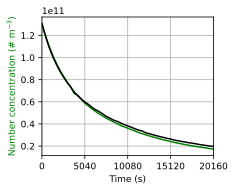

In [19]:
plt.xlabel("Time (s)")
plt.plot(time, num_conc, "g", label="num conc")
plt.xticks(np.linspace(0, time[-1], 5))
plt.xlim([time[0],time[-1]])
plt.ylabel(r"Number concentration ($\#$ m$^{-3}$)", color='g')
barrel = np.loadtxt('ref_aero_time.txt')
plt.plot(barrel[:,0],barrel[:,1],'k')
show_plot()

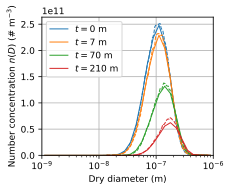

In [20]:
plot_times = [0,1,10,30]
barrel = np.loadtxt('ref_aero_size_num.txt')
diams_barrel = barrel[:,0]

for plot_time in plot_times:
    p = plt.plot(diam_grid.centers, np.array(dists[plot_time]) * np.log(10),
             label=f'$t = {dist_times[plot_time] / 60:0.0f}$ m', lw=1)
    plt.plot(diams_barrel, barrel[:,plot_time+1],'--',c=p[0].get_color(),lw=1)
plt.xscale("log")
plt.xlabel("Dry diameter (m)")
plt.ylabel(r"Number concentration $n(D)$ ($\#$ m$^{-3}$)")
plt.ylim(bottom=0)
plt.legend()
plt.xlim([diam_grid.edges[0],diam_grid.edges[-1]])
show_plot()